In [1]:
import os
import subprocess
import sys
import autograd.numpy as np
import itertools
import json
from tqdm import tqdm
from IPython.display import display, HTML
import time
import pickle
import copy
import scipy.stats
from collections import namedtuple, deque
top_level_dir = '/'.join( os.getcwd().split( '/' )[ :-2 ] )
if top_level_dir not in sys.path:
    sys.path.append( top_level_dir )
%load_ext autoreload
%autoreload 2
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from GenModels.GM.Distributions import Categorical, Dirichlet, TensorTransition, TensorTransitionDirichletPrior
from GenModels.research.PedigreeLoader import load
from GenModels.research.PedigreeWrappers import Pedigree, PedigreeSexMatters
from GenModels.research.Models import *

In [3]:

from autograd.extend import primitive, defvjp

def logsumexp( v, axis=0 ):
    max_v = np.max( v )
    return np.log( np.sum( np.exp( v - max_v ), axis=axis ) ) + max_v

def logsumexp_vjp( ans, x ):
    x_shape = x.shape
    return lambda g: np.full( x_shape, g ) * np.exp( x - np.full( x_shape, ans ) )

defvjp( logsumexp, logsumexp_vjp )


In [4]:
np.random.seed( 2 )
graphs = load()

Graph 4671AT.json is incorrect. 10
Graph 371KD.json is incorrect. 6
Graph 6030CH.json is incorrect. 25
Graph 3743MH.json is incorrect. -1
Graph 5470NG.json is incorrect. -1
Graph 928DW.json is incorrect. -5
Graph 6210HG.json is incorrect. 21
Graph 2049EE.json is incorrect. -1
Graph 1044IO.json is incorrect. -1
Graph 773SM.json is incorrect. 30
Graph 5833TK.json is incorrect. 2
Graph 5738AT.json is incorrect. Can't have an edge with no children!!!!
Graph 3427NF.json is incorrect. -1
Graph 4956RL.json is incorrect. 3
Graph 5022KK.json is incorrect. 31
Graph 5101LV.json is incorrect. 3
Graph 3420MZ.json is incorrect. 2
Graph 3515JA.json is incorrect. 2
Graph 5865MH.json is incorrect. This graph is disjoint!!!
Graph 3919MR.json is incorrect. 1
Graph 473DM.json is incorrect. 30
Graph NEI_INVPK971KPR.json is incorrect. Can't have an edge with no children!!!!
Graph 4737AL.json is incorrect. 2
Graph 5697MS.json is incorrect. 3
Graph 6199RS.json is incorrect. 14
Graph 4835MM.json is incorrect. 

In [12]:
folder_name = '/home/eddie/Desktop/Pedigrees'
for graph, fbs in graphs:
    ip = graph.inheritancePattern
    
    d = graph.draw()

    name = folder_name + '/%s_%s'%( graph.studyID, ip )
#     print( name )
    d.render( name, view=False, cleanup=True )

In [17]:
for g, _ in graphs:
    for n in g.nodes:
        other_info = g.attrs[ n ][ 'other_info' ].lower()
        for k in keywords:
            if( k in other_info ):
                print( other_info )

born premature vision problems
adopted; no family history; leukemia; legally blind by time started college
glasses; diabetic no eye exam- no as
last eye exam within last 6 months
died of prostate cancer; macular degeneration in 50s; cataract surgery
died of prostate cancer; macular degeneration in 50s; cataract surgery
vision loss in 40s to 50s; blind in late 50s; used cane; died of brain aneurysm
vision loss in 40s to 50s; blind in late 50s; used cane; died of brain aneurysm
night blindness and peripheral vision problems at 13
night blindness and peripheral vision problems at 13
diabetic; cataract
mild blindness
vision problems
night blindness, poor periphery, almost blind now
color blind
macular degeneration
pre-diabetes cataracts; detached retina in 50s; car accident in 20s; thyroid problems?
pre-diabetes cataracts; detached retina in 50s; car accident in 20s; thyroid problems?
rp; peripheral vision probs noticed ~30s; night vision probs ~29y; doesn't see stars since 32; glare
rp; p

In [16]:
keywords = [ 'retina',
'blind',
'affected',
'mac',
'glaucoma',
'vision',
'see',
'cataract',
'eye' ]

In [111]:
spell_checker = {
    'africaamerican': 'africanamerican',
    'ashjewish': 'ashkenazijewish',
    'ashkenawjewish': 'ashkenazijewish',
    'austria': 'austrian',
    'autrian': 'austrian',
    'britishisles': 'english',
    'british': 'english',
    'caucasian(ks)': 'caucasian',
    'caucasion': 'caucasian',
    'czechrepublic': 'czech',
    'engl': 'english',
    'englaish': 'english',
    'england': 'english',
    'englishcanadian': 'english',
    'englishirish': 'english',
    'france': 'french',
    'frenchcanadian': 'french',
    'gech': 'german',
    'germans': 'german',
    'germany': 'german',
    'halian': 'halion',
    'haly': 'halion',
    'india': 'indian',
    'irel': 'israel',
    'italy': 'italian',
    'lebanon': 'lebanese',
    'mexico': 'mexican',
    'mixedeuro': 'german',
    'northerneuropean': 'finish',
    'montana': 'american',
    'nativeamericanscc': 'nativeamerican',
    'nativeamerice': 'nativeamerican',
    'notlisted': '',
    'puertorico': 'puertorican',
    'romania': 'romanian',
    'russia': 'russian',
    'scotch': 'scottish',
    'scotish': 'scottish',
    'spain': 'spanish',
    'swiss': 'sweedish',
    'swedish': 'sweedish',
    'ukraine': 'ukrainian',
    'ukranian': 'ukrainian',
    'ukrain': 'ukrainian',
    'unknown': '',
    'unknowncaucasian': 'caucasian',
    'wales': 'welsh',
    'westerneuropean': 'english'
}

def parseEthnicity( ethnicity ):
    if( '/' in ethnicity ):
        ethnicities = ethnicity.split( '/' )
    elif( ';' in ethnicity ):
        ethnicities = ethnicity.split( ';' )
    elif( ',' in ethnicity ):
        ethnicities = ethnicity.split( ',' )
    elif( 'and' in ethnicity ):
        ethnicities = ethnicity.split( 'and' )
    else:
        ethnicities = [ ethnicity ]
        
    return [ e.lower().replace( ' ', '' ).replace( '.', '' ).replace( '-', '' )  for e in ethnicities ]

all_ethnicities = set()
for g, _ in graphs:
    for e in parseEthnicity( g.ethnicity1 ) + parseEthnicity( g.ethnicity2 ):
        if( e in mapper ):
            all_ethnicities.add( spell_checker[ e ] )
        else:
            all_ethnicities.add( e )

ethnicity_map = { 'african': 'african','africanamerican': 'north america','american': 'north america','ashkenazijewish': 'middle east','austrian': 'europe','belarus': 'europe','belgium': 'europe','caucasian': 'europe','centralrussia': 'russia','cherokee': 'native american','chinese': 'china','czachrepublic': 'europe','czech': 'europe','danish': 'europe','dominicanrepublic': 'central america','dutch': 'europe','easterneuropean': 'europe','ecuador': 'central america','egyptian': 'middle east','elsalvador': 'central america','english': 'europe','equador': 'central america','european': 'europe','finish': 'europe','french': 'europe','german': 'europe','greek': 'europe','gypsie': 'europe','halion': 'india','hispanic': 'central america','holland': 'europe','indian': 'india','iran': 'middle east','iraq': 'middle east','irish': 'europe','israel': 'middle east','italian': 'europe','japanese': 'asia','korean': 'asia','lebanese': 'middle east','lithuanian': 'europe','mexican': 'central america','nativeamerican': 'north america','northkorea': 'asia','norway': 'europe','polish': 'europe','puertorican': 'central america','romanian': 'europe','russian': 'russia','scottish': 'europe','southkorea': 'asia','spanish': 'europe','sweedish': 'europe','syrian': 'middle east','ukrainian': 'russia','unitedarabemirates': 'middle east','welsh': 'europe' }
ethnicities = set()
for e in all_ethnicities:
    if( e == '' ):
        continue
    ethnicities.add( ethnicity_map[ e ] )

In [112]:
ethnicities

{'african',
 'asia',
 'central america',
 'china',
 'europe',
 'india',
 'middle east',
 'native american',
 'north america',
 'russia'}

In [ ]:
continents

In [5]:
len( graphs )

430

In [301]:
# ad_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'AD' if np.array( list( graph.data.values() ) ).sum() > 1 ]
# ar_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'AR' if np.array( list( graph.data.values() ) ).sum() > 1 ]
# xl_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'XL' if np.array( list( graph.data.values() ) ).sum() > 1 ]
ad_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'AD' ]
ar_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'AR' ]
xl_graphs = [ ( graph, fbs ) for graph, fbs in graphs if graph.inheritancePattern == 'XL' ]

print( 'Number of graphs for AD: %d AR: %d XL: %d'%( len( ad_graphs ), len( ar_graphs ), len( xl_graphs )) )

Number of graphs for AD: 132 AR: 197 XL: 98


# Estimating E[ P( Y ) ] using Mendellian priors is biased towards autosomal recessive

In [302]:
def evaluationGraphs( graph_and_fbs, set_latent_states=False, set_root_latent_states=True ):
    assert not( set_latent_states == True and set_root_latent_states == True )
    
    graph, fbs = graph_and_fbs

    graph_sex_matters = graph if isinstance( graph, PedigreeSexMatters ) else PedigreeSexMatters.fromPedigree( graph )
    graph_sex_doesnt_matters = graph if isinstance( graph, Pedigree ) else Pedigree.fromPedigreeSexMatters( graph )
    
    ad_graph = copy.deepcopy( graph_sex_doesnt_matters )
    ar_graph = copy.deepcopy( graph_sex_doesnt_matters )
    xl_graph = copy.deepcopy( graph_sex_matters )

    if( set_root_latent_states ):
        ad_graph.useRootDiagnosisImplication( 'AD' )
        ar_graph.useRootDiagnosisImplication( 'AR' )
        xl_graph.useRootDiagnosisImplication( 'XL' )        
    if( set_latent_states ):
        ad_graph.useDiagnosisImplication( 'AD' )
        ar_graph.useDiagnosisImplication( 'AR' )
        xl_graph.useDiagnosisImplication( 'XL' )


    return ( ad_graph, fbs ), ( ar_graph, fbs ), ( xl_graph, fbs )

def onlineMeanUpdate( mean, val, N ):
    return mean + ( val - mean ) / N

def normalizedScores( ad_score, ar_score, xl_score ):
    normalizer = logsumexp( [ ad_score, ar_score, xl_score ] )
    probs = np.array( [ np.exp( ad_score - normalizer ), np.exp( ar_score - normalizer ), np.exp( xl_score - normalizer ) ] )
    return probs

def distributionComparison( graph, samples=400, root_strength=4, strength=4, set_latent_states=False, set_root_latent_states=True ):

    # Fill in assumptions that we can make about each graph
    ad_graph, ar_graph, xl_graph = evaluationGraphs( graph, set_latent_states=set_latent_states, set_root_latent_states=set_root_latent_states )
    
    ad_scores, ar_scores, xl_scores = [], [], []
#     ad_score, ar_score, xl_score = 0.0, 0.0, 0.0
    
    ad_eval = AutosomalDominant( [ ad_graph ], root_strength=root_strength, prior_strength=strength, method='Gibbs' )
    for i in range( samples ):
        ad_eval.sampleParams()
        ad_scores.append( ad_eval.marginal() )
#         ad_score = onlineMeanUpdate( ad_score, ad_eval.marginal(), i+1 )
    ad_eval.msg.cleanup()
    
    ar_eval = AutosomalRecessive( [ ar_graph ], root_strength=root_strength, prior_strength=strength, method='Gibbs' )
    for i in range( samples ):
        ar_eval.sampleParams()
        ar_scores.append( ar_eval.marginal() )
#         ar_score = onlineMeanUpdate( ar_score, ar_eval.marginal(), i+1 )
    ar_eval.msg.cleanup()
    
    xl_eval = XLinkedRecessive( [ xl_graph ], root_strength=root_strength, prior_strength=strength, method='Gibbs' )
    for i in range( samples ):
        xl_eval.sampleParams()
        xl_scores.append( xl_eval.marginal() )
#         xl_score = onlineMeanUpdate( xl_score, xl_eval.marginal(), i+1 )     
    xl_eval.msg.cleanup()
                        
    ad_score = logsumexp( ad_scores ) - np.log( len( ad_scores ) )
    ar_score = logsumexp( ar_scores ) - np.log( len( ar_scores ) )
    xl_score = logsumexp( xl_scores ) - np.log( len( xl_scores ) )
    
    probs = normalizedScores( ad_score, ar_score, xl_score )
#     probs = normalizedScores( ad_score, ar_score, xl_score )
    
    # Sort the scores and return the corresponding inheritance pattern
    ad_comp = ( ad_score, 'AD' )
    ar_comp = ( ar_score, 'AR' )
    xl_comp = ( xl_score, 'XL' )
    
    possibilities = [ ad_comp, ar_comp, xl_comp ]
    return sorted( possibilities, key=lambda x: x[ 0 ] )[ -1 ][ 1 ], probs, ad_scores, ar_scores, xl_scores, ad_eval, ar_eval, xl_eval

In [303]:
def classAccuracy( label, predicted, true ):
    predicted_label = predicted[ true == label ]
    return ( predicted_label == label ).sum() / predicted_label.shape[ 0 ]

In [641]:
def confusionMatrix( predicted, true, labels, ax=None ):
    mat = confusion_matrix( true, predicted, labels=labels )
    correct = mat[ 0,0 ] + mat[ 1,1 ] + mat[ 2,2 ]
    print( mat )
    mat = mat / mat.sum( axis=1 )[ :, None ]
    print( mat )
    if( labels == [ 0, 1, 2 ] ):
        labels = [ 'AD', 'AR', 'XL' ]
    if( ax is None ):
        plt.imshow( mat, interpolation='nearest' )
        plt.clim( 0, 1 )
        plt.colorbar()

        for i, j in itertools.product( range( mat.shape[ 0 ] ), range( mat.shape[ 1 ] ) ):
            plt.text( j, i, format( mat[ i, j ], '.2f' ), color='black' if mat[ i, j ] > mat.max() / 2 else 'white', horizontalalignment='center' )
        
        plt.xticks( [ 0, 1, 2 ], labels )
        plt.yticks( [ 0, 1, 2 ], labels )
        
        plt.ylabel( 'True' )
        plt.xlabel( 'Predicted' )
        plt.show()
    
    print( 'Number of AD', len( [ t for t in true if t == 'AD' or t == 0 ] ) )
    print( 'Number of AR', len( [ t for t in true if t == 'AR' or t == 1 ] ) )
    print( 'Number of XL', len( [ t for t in true if t == 'XL' or t == 2 ] ) )
    print( 'Accuracy:', correct/len( true ) )
    print( 'AD Accuracy:', mat[ 0,0 ] )
    print( 'AR Accuracy:', mat[ 1,1 ] )
    print( 'XL Accuracy:', mat[ 2,2 ] )
    print( 'Cohen Kappa', cohen_kappa_score( true, predicted ) )

In [305]:
def fullPredictions( ad_graphs, ar_graphs, xl_graphs, N=100, root_strength=4, strength=4, set_latent_states=False, set_root_latent_states=True ):
    n_graphs = len( ad_graphs ) + len( ar_graphs ) + len( xl_graphs )
    results = []
    with tqdm( total=n_graphs ) as pbar:
        for graph in ad_graphs:
            res = distributionComparison( graph, samples=N, set_latent_states=set_latent_states, set_root_latent_states=set_root_latent_states, root_strength=root_strength, strength=strength )
            ip, probs, _, _, _, ad_eval, ar_eval, xl_eval = res
            results.append( ( graph, ip, 'AD', probs, ad_eval, ar_eval, xl_eval ) )
            pbar.update( 1 )

        for graph in ar_graphs:
            res = distributionComparison( graph, samples=N, set_latent_states=set_latent_states, set_root_latent_states=set_root_latent_states, root_strength=root_strength, strength=strength ) 
            ip, probs, _, _, _, ad_eval, ar_eval, xl_eval = res
            results.append( ( graph, ip, 'AR', probs, ad_eval, ar_eval, xl_eval ) )
            pbar.update( 1 )

        for graph in xl_graphs:
            res = distributionComparison( graph, samples=N, set_latent_states=set_latent_states, set_root_latent_states=set_root_latent_states, root_strength=root_strength, strength=strength ) 
            ip, probs, _, _, _, ad_eval, ar_eval, xl_eval = res
            results.append( ( graph, ip, 'XL', probs, ad_eval, ar_eval, xl_eval ) )
            pbar.update( 1 )
            
    _, predicted, true, _, _, _, _ = list( zip( *results ) )
    
    confusionMatrix( predicted, true, [ 'AD', 'AR', 'XL' ] )
    
    return results

In [306]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import matplotlib.pyplot as plt

In [307]:
def softMatrix( results ):
    _, predicted, true, all_probs, _, _, _ = list( zip( *results ) )
    ad_probs = np.array( [ p for p, t in zip( all_probs, true ) if t == 'AD' ] )
    ar_probs = np.array( [ p for p, t in zip( all_probs, true ) if t == 'AR' ] )
    xl_probs = np.array( [ p for p, t in zip( all_probs, true ) if t == 'XL' ] )
    ad_soft = ad_probs.sum( axis=0 ) / ad_probs.sum()
    ar_soft = ar_probs.sum( axis=0 ) / ar_probs.sum()
    xl_soft = xl_probs.sum( axis=0 ) / xl_probs.sum()
    return np.vstack( ( ad_soft, ar_soft, xl_soft ) )

In [308]:
N = 100
# Randomly sample 10 graphs from each class to do inference on
K = 5
ind_ad = np.random.choice( len( ad_graphs ), size=min( K, len( ad_graphs ) ), replace=False )
ind_ar = np.random.choice( len( ar_graphs ), size=min( K, len( ar_graphs ) ), replace=False )
ind_xl = np.random.choice( len( xl_graphs ), size=min( K, len( xl_graphs ) ), replace=False )

In [309]:
# ad_test = [ ad_graphs[ i ] for i in ind_ad if ad_graphs[ i ][ 0 ].getNumbAffected() > 1 ]
# ar_test = [ ar_graphs[ i ] for i in ind_ar if ar_graphs[ i ][ 0 ].getNumbAffected() > 1 ]
# xl_test = [ xl_graphs[ i ] for i in ind_xl if xl_graphs[ i ][ 0 ].getNumbAffected() > 1 ]
ad_test = [ ad_graphs[ i ] for i in ind_ad ]
ar_test = [ ar_graphs[ i ] for i in ind_ar ]
xl_test = [ xl_graphs[ i ] for i in ind_xl ]
print( 'len( ad_test )', len( ad_test ) )
print( 'len( ar_test )', len( ar_test ) )
print( 'len( xl_test )', len( xl_test ) )

len( ad_test ) 5
len( ar_test ) 5
len( xl_test ) 5


In [310]:
RETRAIN = False

In [311]:
if( RETRAIN ):
    # results = fullPredictions( ad_graphs, ar_graphs, xl_graphs, N=3, root_strength=1000000000, strength=10000, set_latent_states=False )
    # results = fullPredictions( ad_test, ar_test, xl_test, N=5, root_strength=1000000000, strength=10000, set_latent_states=False, set_root_latent_states=True )
    # results = fullPredictions( ad_test, ar_test, xl_test, N=8, root_strength=1000000000, strength=1000000, set_latent_states=True, set_root_latent_states=False )
    results = fullPredictions( ad_graphs, ar_graphs, xl_graphs, N=20, root_strength=1000000000, strength=1000000, set_latent_states=True, set_root_latent_states=False )
else:
    results = pickle.load( open( 'full_results.p', 'rb' ) )

In [312]:
softMatrix( results )

ValueError: not enough values to unpack (expected 7, got 4)

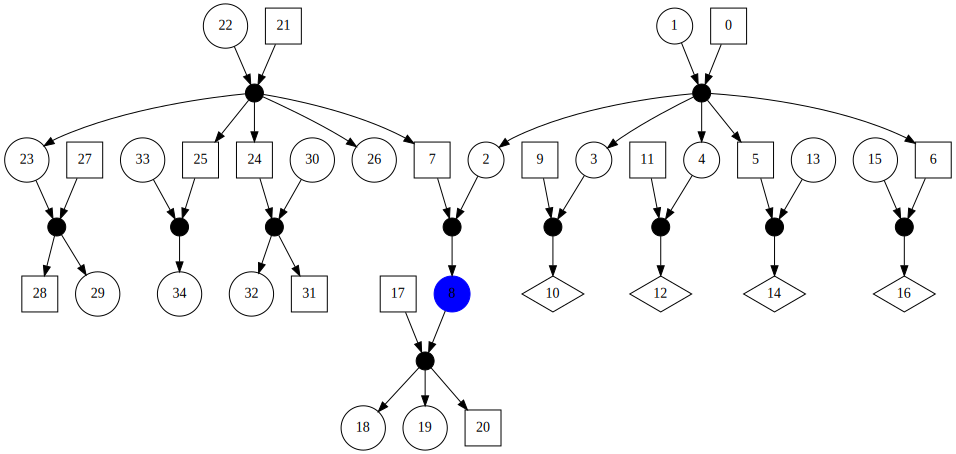

In [313]:
results[ 0 ][ 0 ][ 0 ].draw()

In [ ]:
# it = iter( [ r for r in results if r[ 1 ] != r[ 2 ] ] )

In [ ]:
# ( graph, _ ), predicted, true, prob, ad, ar, xl = next( it )
# print( 'Predicted:', predicted, ', True:', true, ', Prob:', prob )
# display( ad.draw( show_carrier_prob=True ) )
# print( '---------------------------------------------------------------------------------------' )
# display( ar.draw( show_carrier_prob=True ) )
# print( '---------------------------------------------------------------------------------------' )
# display( xl.draw( show_carrier_prob=True ) )

In [ ]:
assert 0

In [ ]:
ad_consanguinity = [ ( ( graph, fbs ), ip, prob ) for ( graph, fbs ), ip, prob in ad_results if fbs.shape[ 0 ] > 0 ]
ar_consanguinity = [ ( ( graph, fbs ), ip, prob ) for ( graph, fbs ), ip, prob in ar_results if fbs.shape[ 0 ] > 0 ]
xl_consanguinity = [ ( ( graph, fbs ), ip, prob ) for ( graph, fbs ), ip, prob in xl_results if fbs.shape[ 0 ] > 0 ]

In [ ]:
len( xl_consanguinity )

In [ ]:
def check( it ):
    current_graph = next( it )
    ( graph, fbs ), true_ip, prob = current_graph
    print( 'True IP:', true_ip, 'probs', prob, 'fbs', fbs )
    return graph.draw()

In [ ]:
it = iter( ar_consanguinity )

In [ ]:
check( it )

1: Percentage of males affected
2: Number of affected people
3: Number of affected generations

# Generate 10 random pedigrees with varying percentage of affected males

# This should be 2d, x axis -> number of affected, y axis -> percentage of males affected


In [ ]:
def randomPedigreeShape():
    # Probability of mating with new person / existing person / being single
    # New person -> p.  Remaining 1-p
    #    In remaining, select existing person with prob proportional to age similarity
    #    Remaining is going to being single
    # Probability of generating male / female / stopping
    #    New child -> q.  Remining 1-q
    
    pass

In [ ]:
Person = namedtuple( 'Person', [ 'name', 'sex', 'shaded' ] )

def matingProcess( n_initial=3, 
                   new_mate_prob=0.5, 
                   mate_unshaded_prob=0.9,
                   no_consanguinity_prob=1.0,
                   n_children_prob=0.65,
                   son_unshaded_prob=0.9,
                   daughter_unshaded_prob=0.9 ):
    people = []
    graph = Pedigree()
    q = deque()
    
    n_initial = 3
    for i in range( n_initial ):
        sex = 'female' if np.random.random() > 0.5 else 'male'
        shading = 0
        person = Person( i, sex, shading )
        q.append( person )
        people.append( person )
    
    while( len( q ) > 0 ):
        
        p = q.popleft()
    
        # Choose who to mate with
        if( np.random.random() < new_mate_prob ):
            m = len( people ) + 1
            m_sex = 'female' if p.sex == 'male' else 'male'
            m_shaded = 1 if np.random.random() > mate_unshaded_prob else 0
            mate = Person( m, m_sex, m_shaded )
            people.append( mate )
        else:
            if( np.random.random() > no_consanguinity_prob ):
                # Skipping this for the moment
                assert 0
            else:
                continue
                
        if( m is None ):
            continue
            
        # Choose how many kids to have
        numb_children = scipy.stats.geom( p=n_children_prob ).rvs( size=1 )
        children = []
        for c in range( numb_children[ 0 ] ):
            c = len( people ) + 1
            c_sex, unshaded_prob = ( 'female', daughter_unshaded_prob ) if np.random.random() > 0.5 else ( 'male', son_unshaded_prob )
            c_shaded = 1 if np.random.random() > unshaded_prob else 0
            child = Person( c, c_sex, c_shaded )
            q.append( child )
            people.append( child )
            children.append( child )
            
        sorted_parents = sorted( [ p, mate ], key=lambda x: x.sex )
        parent_ids = [ _p.name for _p in sorted_parents ]
        child_ids = [ _c.name for _c in children ]        
        graph.addEdge( parents=parent_ids, children=child_ids )
        
        for n in sorted_parents + children:
            graph.setNodeAttrs( n.name, { 'sex': n.sex, 'affected': n.shaded } )
        
        if( len( people ) > 50 ):
            # Max number of people
            return graph
            
    return graph

In [ ]:
graphs = []
for _ in range( 5 ):
    graph = matingProcess( n_initial=3, 
                            new_mate_prob=0.8, 
                            mate_unshaded_prob=0.95,
                            no_consanguinity_prob=1.0,
                            n_children_prob=0.65,
                            son_unshaded_prob=0.9,
                            daughter_unshaded_prob=0.9 )
    graphs.append( graph )
    
for graph in graphs:
    n_males = sum( [ 1 for _, sex, shaded in graph.people if sex == 'male' ] )
    n_females = sum( [ 1 for _, sex, shaded in graph.people if sex == 'male' ] )    
    n_shaded_males = sum( [ 1 for _, sex, shaded in graph.people if sex == 'male' and shaded == 1 ] )
    n_shaded_females = sum( [ 1 for _, sex, shaded in graph.people if sex == 'female' and shaded == 1 ] )
    print( 'n', len( graph.people ), 'n_males', n_males, 'n_females', n_females, 'n_shaded_males', n_shaded_males, 'n_shaded_females', n_shaded_females )
    display( graph.draw() )
    assert 0

In [ ]:
graph.draw()

In [ ]:
array([0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 0, 0, 1, 1, 2, 0, 0, 2, 0, 1, 0, 0, 2, 0, 1, 2, 2,
       0, 0, 2, 1, 0, 2, 0, 2, 2, 1, 2, 1, 0, 2, 1, 0, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0])

In [409]:
print( len( ad_confident_correct ) + len( ad_confident_wrong ) )
print( len( ar_confident_correct ) + len( ar_confident_wrong ) )
print( len( xl_confident_correct ) + len( xl_confident_wrong ) )

89
61
64


In [410]:
all_confident = ad_confident_correct + ad_confident_wrong + ar_confident_correct + ar_confident_wrong + xl_confident_correct + xl_confident_wrong

In [411]:
len( all_confident )

214

In [412]:
folder_name = 'all_confident'
if( False ):
    for ( graph, fbs ), predicted, true_ip, prob in all_confident:
        d = graph.draw()
        name = folder_name + '/%s__AD_%1.2f_AR_%1.2f_XL_%1.2f_TRUE_%s_PRED_%s'%( graph.studyID, prob[ 0 ], prob[ 1 ], prob[ 2 ], true_ip, predicted )
        print( name )
        d.render( name, view=False, cleanup=True )

In [643]:
true_ips = list( zip( *all_confident ) )[ -2 ]
predicted_ips = list( zip( *all_confident ) )[ -3 ]
labels = [ 'AD', 'AR', 'XL' ]
true_ips = np.array( [ labels.index( ip ) for ip in true_ips ] )
predicted_ips = np.array( [ labels.index( ip ) for ip in predicted_ips ] )

[[73 12  4]
 [21 24 16]
 [15  4 45]]
[[0.82022472 0.13483146 0.04494382]
 [0.3442623  0.39344262 0.26229508]
 [0.234375   0.0625     0.703125  ]]


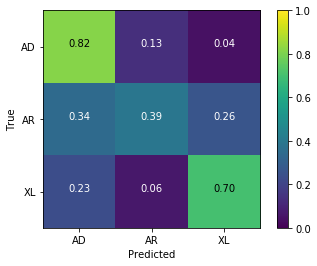

Number of AD 89
Number of AR 61
Number of XL 64
Accuracy: 0.6635514018691588
AD Accuracy: 0.8202247191011236
AR Accuracy: 0.39344262295081966
XL Accuracy: 0.703125
Cohen Kappa 0.47760637396168837


In [644]:
confusionMatrix( predicted_ips, true_ips, labels=[0,1,2] )

In [418]:
if( False ):
    my_answers = []
    for ( graph, fbs ), predicted, true_ip, prob in all_confident:
        display( graph.draw() )
        my_ans = input( 'Inheritance guess' )
        my_answers.append( my_ans )
        human_ips = np.array( [ labels.index( i ) for i in my_answers ] )
else:
    human_ips = np.array([0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 0, 0, 1, 1, 2, 0, 0, 2, 0, 1, 0, 0, 2, 0, 1, 2, 2,
       0, 0, 2, 1, 0, 2, 0, 2, 2, 1, 2, 1, 0, 2, 1, 0, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0])

In [419]:
human_ips

array([0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 0, 0, 1, 1, 2, 0, 0, 2, 0, 1, 0, 0, 2, 0, 1, 2, 2,
       0, 0, 2, 1, 0, 2, 0, 2, 2, 1, 2, 1, 0, 2, 1, 0, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0])

In [420]:
predicted_ips

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0,
       0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0])

In [421]:
( human_ips == predicted_ips ).sum()

188

In [422]:
confusion_matrix( human_ips, predicted_ips )

array([[100,   4,   2],
       [  3,  35,  10],
       [  6,   1,  53]])

[[100   4   2]
 [  3  35  10]
 [  6   1  53]]
[[0.94339623 0.03773585 0.01886792]
 [0.0625     0.72916667 0.20833333]
 [0.1        0.01666667 0.88333333]]


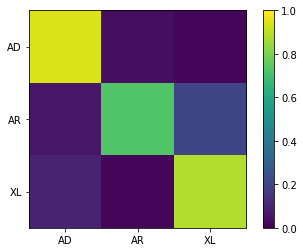

Number of AD 106
Number of AR 48
Number of XL 60
Accuracy: 0.8785046728971962
AD Accuracy: 0.9433962264150944
AR Accuracy: 0.7291666666666666
XL Accuracy: 0.8833333333333333
Cohen Kappa 0.8042361550911266


In [439]:
confusionMatrix(true=human_ips, predicted=predicted_ips, labels=[0,1,2])

In [426]:
(101+37+50)/len( my_answers )

0.8785046728971962

[[100   4   2]
 [  3  35  10]
 [  6   1  53]]
[[0.94339623 0.03773585 0.01886792]
 [0.0625     0.72916667 0.20833333]
 [0.1        0.01666667 0.88333333]]


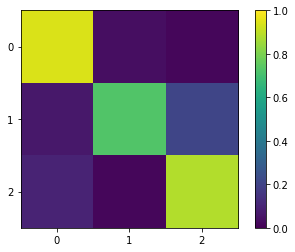

Number of AD 106
Number of AR 48
Number of XL 60
Accuracy: 0.8785046728971962
AD Accuracy: 0.9433962264150944
AR Accuracy: 0.7291666666666666
XL Accuracy: 0.8833333333333333
Cohen Kappa 0.8042361550911266


In [427]:
confusionMatrix(true=human_ips, predicted=predicted_ips, labels=[0,1,2])

In [293]:
folder_name = 'disagree_algorithm_correct'
for i, ( ( graph, fbs ), predicted, true_ip, prob ) in enumerate( all_confident ):
    if( human_ips[ i ] != predicted_ips[ i ] and predicted == true_ip ):
        d = graph.draw()
        name = folder_name + '/%s__MYPRED_%s_PRED_%s_TRUE_%s'%( graph.studyID, my_answers[ i ], predicted, true_ip )
        print( name )
        d.render( name, view=False, cleanup=True )

disagree_algorithm_correct/NEI_INVVH314FE8__MYPRED_XL_PRED_AD_TRUE_AD
disagree_algorithm_correct/611JC__MYPRED_AD_PRED_AR_TRUE_AR
disagree_algorithm_correct/NEI_INVLD750EXK__MYPRED_AD_PRED_AR_TRUE_AR
disagree_algorithm_correct/405JA__MYPRED_AR_PRED_XL_TRUE_XL
disagree_algorithm_correct/NEI_INVBX298MH5__MYPRED_AR_PRED_XL_TRUE_XL
disagree_algorithm_correct/NEI_INVLP180BFG__MYPRED_AD_PRED_XL_TRUE_XL
disagree_algorithm_correct/5191BD__MYPRED_AR_PRED_XL_TRUE_XL
disagree_algorithm_correct/671AH__MYPRED_AR_PRED_XL_TRUE_XL


In [294]:
folder_name = 'disagree_myprediction_correct'
for i, ( ( graph, fbs ), predicted, true_ip, prob ) in enumerate( all_confident ):
    if( human_ips[ i ] != predicted_ips[ i ] and my_answers[ i ] == true_ip ):
        d = graph.draw()
        name = folder_name + '/%s__MYPRED_%s_PRED_%s_TRUE_%s'%( graph.studyID, my_answers[ i ], predicted, true_ip )
        print( name )
        d.render( name, view=False, cleanup=True )

disagree_myprediction_correct/3183DG__MYPRED_AD_PRED_XL_TRUE_AD
disagree_myprediction_correct/3235JW__MYPRED_AD_PRED_AR_TRUE_AD
disagree_myprediction_correct/5694JL__MYPRED_AR_PRED_XL_TRUE_AR
disagree_myprediction_correct/NEI_INVGM538ZG1__MYPRED_AR_PRED_XL_TRUE_AR
disagree_myprediction_correct/NEI_INVDP765JX6__MYPRED_AR_PRED_AD_TRUE_AR
disagree_myprediction_correct/NEI_INVPN452HD6__MYPRED_AR_PRED_AD_TRUE_AR
disagree_myprediction_correct/3308WM__MYPRED_AR_PRED_XL_TRUE_AR
disagree_myprediction_correct/NEI_INVAY629ZB8__MYPRED_AR_PRED_XL_TRUE_AR
disagree_myprediction_correct/4224JH__MYPRED_AR_PRED_AD_TRUE_AR
disagree_myprediction_correct/NEI_INVDB542NK4__MYPRED_AR_PRED_XL_TRUE_AR
disagree_myprediction_correct/NEI_INVMK954UYF__MYPRED_XL_PRED_AR_TRUE_XL
disagree_myprediction_correct/NEI_INVJE037JA8__MYPRED_XL_PRED_AD_TRUE_XL


- Skipping male generation

In [297]:
import pandas as pd 

df = pd.read_csv( 'pedigreeAnswers.csv' )

/anaconda3/envs/GenModel/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [298]:
df

,Patient ID,PedAvail,numAff,multGenAff,MAffSon,MAffDau,skipping,sibAff,halfSibAff,cousAff,MFAff,ons20M,FAsymm,FOnset,multDx,consang,lPatDiag,lDiffDiag,lFamAff
0,3007TR,Y,1,False,False,False,1,1,1,1,3,False,Unknown,False,False,False,Disease; ;,NaN,14
1,1011MB,Y,2,True,False,False,1,1,1,1,2,True,False,False,True,False,Stargardt; ;,Macular Degeneration,3; 27
2,1022AS,Y,1,False,False,False,1,1,1,1,3,False,Unknown,False,False,False,Disease; ;,NaN,22
3,1036RC,Y,1,False,False,False,1,1,1,1,2,Unknown,False,False,False,False,Disease; ;,NaN,20
4,1038CG,Y,4,True,False,False,2,1,1,4,2,True,False,False,True,False,DxRS; ;,blind; unknown,8; 18; 36; 39
5,1044IO,Y,2,False,False,False,1,1,1,1,2,True,False,False,True,False,Cone Dystrophy; ;,Cone Dystrophy similarity; unknown,5; 42
6,1046DA,Y,4,True,False,False,3,1,1,1,3,False,Unknown,False,False,False,Disease; ;,NaN,2; 6; 8; 14
7,1075NP,Y,3,True,False,False,2,3,1,1,1,True,Unknown,Unknown,True,False,Disease; ;,Nystagmus,7; 23; 25
8,1079JM,Y,1,False,False,False,1,1,1,1,3,False,Unknown,False,False,False,Disease; ;,NaN,16
9,1083BF,Y,3,False,False,False,1,3,1,3,2,Unknown,False,False,True,False,Stargardt; ;,Macular Degeration,24; 25; 695


In [408]:
mask = []
for i, ( ( graph, fbs ), predicted, true_ip, prob ) in enumerate( all_confident ):
    if( graph.getNumbAffected() == 1 ):
        mask.append( False )
    else:
        mask.append( True )
mask = np.array( mask )

NameError: name 'all_confident' is not defined

[[73 12  4]
 [21 24 16]
 [15  4 45]]
[[0.82022472 0.13483146 0.04494382]
 [0.3442623  0.39344262 0.26229508]
 [0.234375   0.0625     0.703125  ]]


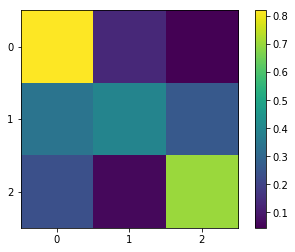

Number of AD 0
Number of AR 0
Number of XL 0
AD Accuracy: 0.8202247191011236
AR Accuracy: 0.39344262295081966
XL Accuracy: 0.703125
Cohen Kappa 0.47760637396168837


In [285]:
confusionMatrix(true=true_ips, predicted=predicted_ips, labels=[0,1,2])

[[74 12  3]
 [16 30 15]
 [16  6 42]]
[[0.83146067 0.13483146 0.03370787]
 [0.26229508 0.49180328 0.24590164]
 [0.25       0.09375    0.65625   ]]


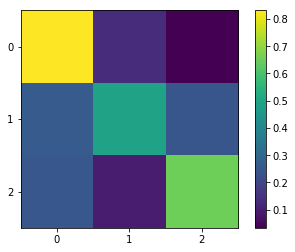

Number of AD 0
Number of AR 0
Number of XL 0
AD Accuracy: 0.8314606741573034
AR Accuracy: 0.4918032786885246
XL Accuracy: 0.65625
Cohen Kappa 0.5082787051429344


In [286]:
confusionMatrix(true=true_ips, predicted=human_ips, labels=[0,1,2])

In [ ]:
assert 0

In [ ]:
import pickle
pickle.dump( [ r[ :-3 ] for r in results ], open( 'full_results.p', 'wb' ) )

In [315]:
# sorted_graphs, predicted, true, all_probs, _, _, _ = list( zip( *results ) )
sorted_graphs, predicted, true, all_probs = list( zip( *results ) )

In [316]:
def separateResults( results ):
    sorted_graphs, predicted, true, all_probs = list( zip( *results ) )
#     sorted_graphs, predicted, true, all_probs, _, _, _ = list( zip( *results ) )
    ad_results, ar_results, xl_results = [], [], []
    for g, p, t, prob in zip( sorted_graphs, predicted, true, all_probs ):
        if( t == 'AD' ):
            ad_results.append( ( g, p, prob ) )
        elif( t == 'AR' ):
            ar_results.append( ( g, p, prob ) )
        else:
            xl_results.append( ( g, p, prob ) )
    return ad_results, ar_results, xl_results

In [317]:
ad_results, ar_results, xl_results = separateResults( results )

In [318]:
CONFIDENT = 0.80
SORTA_CONFIDENT = 0.50
def furtherSeparate( results, true_ip, true_ip_index ):
    confident_correct, confident_wrong, sorta_confident_correct, sorta_confident_wrong, unconfident_correct, unconfident_wrong = [], [], [], [], [], []
    for graph, predicted, prob in results:
        max_predicted = np.max( prob )
        if( predicted == true_ip ):
            if( max_predicted > CONFIDENT ):
                confident_correct.append( ( graph, predicted, true_ip, prob ) )
            elif( max_predicted > SORTA_CONFIDENT ):
                sorta_confident_correct.append( ( graph, predicted, true_ip, prob ) )
            else:
                unconfident_correct.append( ( graph, predicted, true_ip, prob ) )
        else:
            if( max_predicted > CONFIDENT ):
                confident_wrong.append( ( graph, predicted, true_ip, prob ) )
            elif( max_predicted > SORTA_CONFIDENT ):
                sorta_confident_wrong.append( ( graph, predicted, true_ip, prob ) )
            else:
                unconfident_wrong.append( ( graph, predicted, true_ip, prob ) )
    return confident_correct, confident_wrong, sorta_confident_correct, sorta_confident_wrong, unconfident_correct, unconfident_wrong

In [319]:
ad_confident_correct, ad_confident_wrong, ad_sorta_confident_correct, ad_sorta_confident_wrong, ad_unconfident_correct, ad_unconfident_wrong = furtherSeparate( ad_results, 'AD', 0 )
ar_confident_correct, ar_confident_wrong, ar_sorta_confident_correct, ar_sorta_confident_wrong, ar_unconfident_correct, ar_unconfident_wrong = furtherSeparate( ar_results, 'AR', 1 )
xl_confident_correct, xl_confident_wrong, xl_sorta_confident_correct, xl_sorta_confident_wrong, xl_unconfident_correct, xl_unconfident_wrong = furtherSeparate( xl_results, 'XL', 2 )

In [432]:
print( 'ad_confident_correct', len( ad_confident_correct ) )
print( 'ad_confident_wrong', len( ad_confident_wrong ) )
print( 'ad_sorta_confident_correct', len( ad_sorta_confident_correct ) )
print( 'ad_sorta_confident_wrong', len( ad_sorta_confident_wrong ) )
print( 'ad_unconfident_correct', len( ad_unconfident_correct ) )
print( 'ad_unconfident_wrong', len( ad_unconfident_wrong ) )
print()
print( 'ar_confident_correct', len( ar_confident_correct ) )
print( 'ar_confident_wrong', len( ar_confident_wrong ) )
print( 'ar_sorta_confident_correct', len( ar_sorta_confident_correct ) )
print( 'ar_sorta_confident_wrong', len( ar_sorta_confident_wrong ) )
print( 'ar_unconfident_correct', len( ar_unconfident_correct ) )
print( 'ar_unconfident_wrong', len( ar_unconfident_wrong ) )
print()
print( 'xl_confident_correct', len( xl_confident_correct ) )
print( 'xl_confident_wrong', len( xl_confident_wrong ) )
print( 'xl_sorta_confident_correct', len( xl_sorta_confident_correct ) )
print( 'xl_sorta_confident_wrong', len( xl_sorta_confident_wrong ) )
print( 'xl_unconfident_correct', len( xl_unconfident_correct ) )
print( 'xl_unconfident_wrong', len( xl_unconfident_wrong ) )
print()

ad_confident_correct 73
ad_confident_wrong 16
ad_sorta_confident_correct 0
ad_sorta_confident_wrong 20
ad_unconfident_correct 4
ad_unconfident_wrong 19

ar_confident_correct 24
ar_confident_wrong 37
ar_sorta_confident_correct 22
ar_sorta_confident_wrong 13
ar_unconfident_correct 33
ar_unconfident_wrong 68

xl_confident_correct 45
xl_confident_wrong 19
xl_sorta_confident_correct 6
xl_sorta_confident_wrong 3
xl_unconfident_correct 14
xl_unconfident_wrong 11



In [434]:
count = 0
for ( graph, _ ), pred, tru, prob in results:
    if( graph.getNumbAffected() == 1 ):
        if( graph.inheritancePattern == 'AR' ):
            count += 1
print( count )

139


In [435]:
24+13

37

In [433]:
def confidenceLevelMetaStats( ad, ar, xl, ax ):
    # Histogram of number of affected people
    n_affected = []
    for graph, _, _, _ in itertools.chain( ad, ar, xl ):
        n_affected.append( graph[ 0 ].getNumbAffected() )
    ax.hist( n_affected )

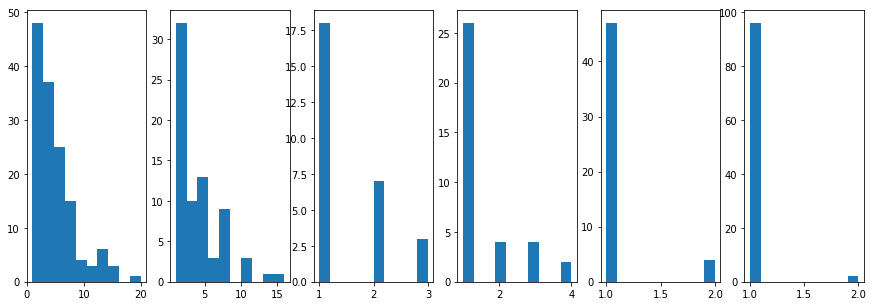

In [322]:
plt.figure( figsize=( 15, 5 ) )
axes = [ plt.subplot2grid( shape=( 1, 6 ), loc=( 0, i ), colspan=1, rowspan=1 ) for i in range( 6 ) ]
confidenceLevelMetaStats( ad_confident_correct, ar_confident_correct, xl_confident_correct, axes[ 0 ] )
confidenceLevelMetaStats( ad_confident_wrong, ar_confident_wrong, xl_confident_wrong, axes[ 1 ] )
confidenceLevelMetaStats( ad_sorta_confident_correct, ar_sorta_confident_correct, xl_sorta_confident_correct, axes[ 2 ] )
confidenceLevelMetaStats( ad_sorta_confident_wrong, ar_sorta_confident_wrong, xl_sorta_confident_wrong, axes[ 3 ] )
confidenceLevelMetaStats( ad_unconfident_correct, ar_unconfident_correct, xl_unconfident_correct, axes[ 4 ] )
confidenceLevelMetaStats( ad_unconfident_wrong, ar_unconfident_wrong, xl_unconfident_wrong, axes[ 5 ] )
plt.show()

In [323]:
def onlyConfident( ad, ar, xl ):
    res = ad + ar + xl
    print( len ( res ) )

(array([51.,  2.,  5., 10.,  6., 33.,  9.,  5.,  2.,  9.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

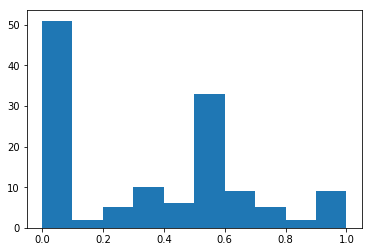

In [324]:
n_affected = []
for graph, _, _ in ad_results:
    ans = 0
    for node, attr in graph[ 0 ].attrs.items():
        if( attr[ 'affected' ] == True and attr[ 'sex' ] == 'male' ):
            ans += 1    
    if( graph[ 0 ].getNumbAffected() > 1 ):
        n_affected.append( ans / graph[ 0 ].getNumbAffected() )    
    else:
        n_affected.append( 0 )  
#     n_affected.append( graph[ 0 ].getNumbAffected() )
plt.hist( n_affected )

(array([151.,   1.,   0.,   6.,   0.,  19.,   4.,   3.,   0.,  13.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

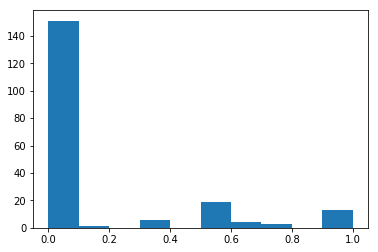

In [325]:
n_affected = []
for graph, _, _ in ar_results:
    ans = 0
    for node, attr in graph[ 0 ].attrs.items():
        if( attr[ 'affected' ] == True and attr[ 'sex' ] == 'male' ):
            ans += 1    
    if( graph[ 0 ].getNumbAffected() > 1 ):
        n_affected.append( ans / graph[ 0 ].getNumbAffected() )    
    else:
        n_affected.append( 0 )    
#     n_affected.append( graph[ 0 ].getNumbAffected() )
plt.hist( n_affected )

(array([39.,  0.,  0.,  4.,  2.,  7.,  7.,  1.,  2., 36.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

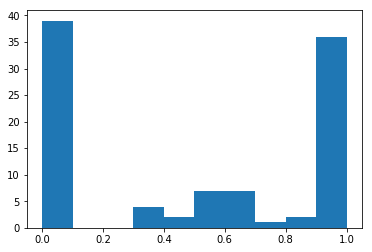

In [326]:
n_affected = []
for graph, _, _ in xl_results:
    ans = 0
    for node, attr in graph[ 0 ].attrs.items():
        if( attr[ 'affected' ] == True and attr[ 'sex' ] == 'male' ):
            ans += 1    
    if( graph[ 0 ].getNumbAffected() > 1 ):
        n_affected.append( ans / graph[ 0 ].getNumbAffected() )    
    else:
        n_affected.append( 0 )     
#     n_affected.append( graph[ 0 ].getNumbAffected() )
plt.hist( n_affected )

In [327]:
def numbAffectedMales( graph ):
    ans = 0
    for node, attr in graph.attrs.items():
        if( attr[ 'affected' ] == 1 and attr[ 'sex' ] == 'male' ):
            ans += 1
    return ans / graph.getNumbAffected()

In [645]:
true = []
predicted = []
for ( graph, _ ), pred, tru, prob in results:
    if( np.max( prob ) < 0.44 ):
        continue

    if( graph.getNumbAffected() == 1 and np.max( prob ) < 0.58 ):
        predicted.append( 'AR' )
    else:
        predicted.append( pred )
    true.append( tru )
predicted = np.array( predicted )
true = np.array( true )

[[73 34  9]
 [22 86 19]
 [15 18 48]]
[[0.62931034 0.29310345 0.07758621]
 [0.17322835 0.67716535 0.1496063 ]
 [0.18518519 0.22222222 0.59259259]]


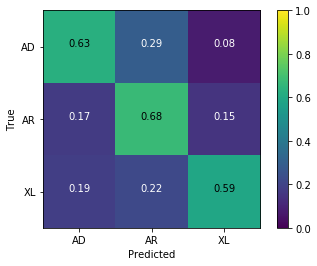

Number of AD 116
Number of AR 127
Number of XL 81
Accuracy: 0.6388888888888888
AD Accuracy: 0.6293103448275862
AR Accuracy: 0.6771653543307087
XL Accuracy: 0.5925925925925926
Cohen Kappa 0.44687308489217026


In [646]:
confusionMatrix( predicted, true, [ 'AD', 'AR', 'XL' ] )

[[73 32  5]
 [21 86 13]
 [15 24 42]]
[[0.66363636 0.29090909 0.04545455]
 [0.175      0.71666667 0.10833333]
 [0.18518519 0.2962963  0.51851852]]


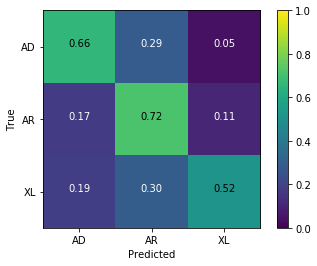

Number of AD 110
Number of AR 120
Number of XL 81
Accuracy: 0.6463022508038585
AD Accuracy: 0.6636363636363637
AR Accuracy: 0.7166666666666667
XL Accuracy: 0.5185185185185185
Cohen Kappa 0.4555235472935335


In [647]:
true = []
predicted = []
for ( graph, _ ), pred, tru, prob in results:
    if( graph.getNumbAffected() == 1 ):
        if( np.random.random() > 0.5 ):
            predicted.append( 'AR' )
        else:
            continue
    else:
        if( np.max( prob ) < 0.75 ):
            continue        
        else:
            predicted.append( pred )

    true.append( tru )
predicted = np.array( predicted )
true = np.array( true )
confusionMatrix( predicted, true, [ 'AD', 'AR', 'XL' ] )

[[73 12  4]
 [21 24 16]
 [15  4 45]]
[[0.82022472 0.13483146 0.04494382]
 [0.3442623  0.39344262 0.26229508]
 [0.234375   0.0625     0.703125  ]]


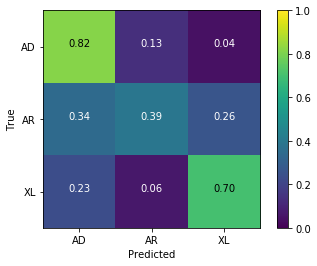

Number of AD 89
Number of AR 61
Number of XL 64
Accuracy: 0.6635514018691588
AD Accuracy: 0.8202247191011236
AR Accuracy: 0.39344262295081966
XL Accuracy: 0.703125
Cohen Kappa 0.47760637396168837


In [651]:
true = []
predicted = []
for ( graph, _ ), pred, tru, prob in results:
    if( np.max( prob ) < 0.8 ):
        continue
    predicted.append( pred )
    true.append( tru )
predicted = np.array( predicted )
true = np.array( true )
confusionMatrix( predicted, true, [ 'AD', 'AR', 'XL' ] )

[[77 33 22]
 [43 79 75]
 [20 13 65]]
[[0.58333333 0.25       0.16666667]
 [0.21827411 0.40101523 0.38071066]
 [0.20408163 0.13265306 0.66326531]]


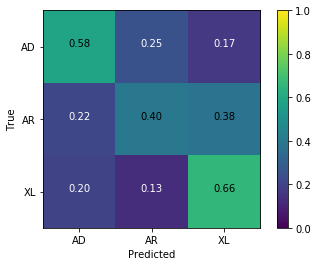

Number of AD 132
Number of AR 197
Number of XL 98
Accuracy: 0.5175644028103045
AD Accuracy: 0.5833333333333334
AR Accuracy: 0.4010152284263959
XL Accuracy: 0.6632653061224489
Cohen Kappa 0.28687939812562835


In [652]:
true = []
predicted = []
for ( graph, _ ), pred, tru, prob in results:
    predicted.append( pred )
    true.append( tru )
predicted = np.array( predicted )
true = np.array( true )
confusionMatrix( predicted, true, [ 'AD', 'AR', 'XL' ] )

In [ ]:
over_one_affected = [ r for r in results if r[ 0 ][ 0 ].getNumbAffected() > 1 ]

In [ ]:
_, predicted, true, _, _, _, _ = list( zip( *over_one_affected ) )
predicted = np.array( predicted )
true = np.array( true )

labels = [ 'AD', 'AR', 'XL' ]
confusionMatrix( predicted, true, labels )

In [ ]:
def confidenceEval( all_of_level ):
    predicted, true = [], []
    for graph, pred, tru, probs in itertools.chain( *all_of_level ):
        predicted.append( pred )
        true.append( tru )
    predicted = np.array( predicted )
    true = np.array( true )
    confusionMatrix( predicted, true, labels )

In [ ]:
all_confident = ad_confident_correct, ad_confident_wrong, ar_confident_correct, ar_confident_wrong, xl_confident_correct, xl_confident_wrong
confidenceEval( all_confident )

In [ ]:
all_sorta_confident = ad_sorta_confident_correct, ad_sorta_confident_wrong, ar_sorta_confident_correct, ar_sorta_confident_wrong, xl_sorta_confident_correct, xl_sorta_confident_wrong
confidenceEval( all_sorta_confident )

In [ ]:
all_unconfident = ad_unconfident_correct, ad_unconfident_wrong, ar_unconfident_correct, ar_unconfident_wrong, xl_unconfident_correct, xl_unconfident_wrong
confidenceEval( all_unconfident )

In [ ]:
# assert 0

In [ ]:
def saveGraphs( results, folder_name ):
    for ( graph, fbs ), predicted, _, prob in results:
        d = graph.draw()
        name = folder_name + '/%s__AD_%1.2f_AR_%1.2f_XL_%1.2f'%( graph.studyID, prob[ 0 ], prob[ 1 ], prob[ 2 ] )
        d.render( name, view=False, cleanup=True )

In [ ]:
saveGraphs( ad_confident_correct, 'ad_confident_correct' )
saveGraphs( ad_confident_wrong, 'ad_confident_wrong' )
saveGraphs( ad_sorta_confident_correct, 'ad_sorta_confident_correct' )
saveGraphs( ad_sorta_confident_wrong, 'ad_sorta_confident_wrong' )
saveGraphs( ad_unconfident_correct, 'ad_unconfident_correct' )
saveGraphs( ad_unconfident_wrong, 'ad_unconfident_wrong' )

saveGraphs( ar_confident_correct, 'ar_confident_correct' )
saveGraphs( ar_confident_wrong, 'ar_confident_wrong' )
saveGraphs( ar_sorta_confident_correct, 'ar_sorta_confident_correct' )
saveGraphs( ar_sorta_confident_wrong, 'ar_sorta_confident_wrong' )
saveGraphs( ar_unconfident_correct, 'ar_unconfident_correct' )
saveGraphs( ar_unconfident_wrong, 'ar_unconfident_wrong' )

saveGraphs( xl_confident_correct, 'xl_confident_correct' )
saveGraphs( xl_confident_wrong, 'xl_confident_wrong' )
saveGraphs( xl_sorta_confident_correct, 'xl_sorta_confident_correct' )
saveGraphs( xl_sorta_confident_wrong, 'xl_sorta_confident_wrong' )
saveGraphs( xl_unconfident_correct, 'xl_unconfident_correct' )
saveGraphs( xl_unconfident_wrong, 'xl_unconfident_wrong' )

In [ ]:
assert 0, 'This is the end of the analysis with only pedigree data'

In [555]:
import pandas as pd 

df = pd.read_csv( 'pedigreeAnswers.csv' )
df_labels = pd.read_csv( 'Complete_pedigree_data.csv' )

# Set the labels for the regular df
for studyID, IP in df_labels[ [ 'Patient ID', 'Inheritance Pattern' ] ].values:
    if( studyID in df[ 'Patient ID' ].values ):
        index = df.index[ df[ 'Patient ID' ] == studyID ][ 0 ]
        df.loc[ index, 'IP' ] = IP

# Drop nan inheritance patterns
bad_mask = df[ 'IP' ].isna()
df = df[ ~bad_mask ]

# Load the ghmm results
results = pickle.load( open( 'full_results.p', 'rb' ) )

# Add the extra features from the ghmm
for ( graph, _ ), _, _, p in sorted( results, key=lambda x: x[ 0 ][ 0 ].studyID ):
    if( graph.studyID in df[ 'Patient ID' ].values ):
        index = df.index[ df[ 'Patient ID' ] == graph.studyID ][ 0 ]
        df.loc[ index, 'AD_Prob' ] = p[ 0 ]
        df.loc[ index, 'AR_Prob' ] = p[ 1 ]
        df.loc[ index, 'XL_Prob' ] = p[ 2 ]
        df.loc[ index, 'nMales' ] = len( [ 1 for n in graph.nodes if graph.attrs[ n ][ 'sex' ] == 'male' ] )
        df.loc[ index, 'nFemales' ] = len( [ 1 for n in graph.nodes if graph.attrs[ n ][ 'sex' ] == 'female' ] )
        df.loc[ index, 'nUnknowns' ] = len( [ 1 for n in graph.nodes if graph.attrs[ n ][ 'sex' ] == 'unknown' ] )
        
        df.loc[ index, 'nAffMales' ] = len( [ 1 for n in graph.nodes if graph.attrs[ n ][ 'sex' ] == 'male' and graph.attrs[ n ][ 'affected' ] ] )
        df.loc[ index, 'nAffFemales' ] = len( [ 1 for n in graph.nodes if graph.attrs[ n ][ 'sex' ] == 'female' and graph.attrs[ n ][ 'affected' ] ] )
        df.loc[ index, 'nAffUnknowns' ] = len( [ 1 for n in graph.nodes if graph.attrs[ n ][ 'sex' ] == 'unknown' and graph.attrs[ n ][ 'affected' ] ] )
        
        df.loc[ index, 'percentageAffMales' ] = df.loc[ index, 'nAffMales' ] / ( df.loc[ index, 'nAffMales' ] + df.loc[ index, 'nAffFemales' ] + df.loc[ index, 'nAffUnknowns' ] )
        
        if( not graph.inheritancePattern == df.loc[ index, 'IP' ] ):
            print( 'graph.inheritancePattern', graph.inheritancePattern )
            print( 'df.loc[ index, \'IP\' ]', df.loc[ index, 'IP' ] )
            assert 0

# Use these features
keep_cols = [ 'Patient ID',
              'numAff',
              'multGenAff',
              'MAffSon',
              'MAffDau',
              'skipping',
              'sibAff',
              'halfSibAff',
              'cousAff',
              'MFAff',
              'ons20M',
              'multDx',
              'consang',
              'nMales',
              'nFemales',
              'nUnknowns',
              'nAffMales',
              'nAffFemales',
              'nAffUnknowns',
              'percentageAffMales',
              'AD_Prob',
              'AR_Prob',
              'XL_Prob',
              'IP' ]

# Drop the rows that we don't have ghmm results for
df = df[ keep_cols ].dropna()
df = df.set_index( 'Patient ID' )

# Drop inheritance patterns that aren't AD, AR or XL
mask = df[ 'IP' ] == 'AD'
mask |= df[ 'IP' ] == 'AR'
mask |= df[ 'IP' ] == 'XL'
df = df[ mask ]

In [556]:
df

,numAff,multGenAff,MAffSon,MAffDau,skipping,sibAff,halfSibAff,cousAff,MFAff,ons20M,...,nFemales,nUnknowns,nAffMales,nAffFemales,nAffUnknowns,percentageAffMales,AD_Prob,AR_Prob,XL_Prob,IP
Patient ID,,,,,,,,,,,,,,,,,,,,,
1022AS,1,False,False,False,1,1,1,1,3,False,...,13.0,4.0,0.0,1.0,0.0,0.000000,1.952661e-01,8.047339e-01,4.261081e-12,AR
1036RC,1,False,False,False,1,1,1,1,2,Unknown,...,8.0,0.0,1.0,0.0,0.0,1.000000,2.944810e-01,3.381087e-01,3.674103e-01,AR
1046DA,4,True,False,False,3,1,1,1,3,False,...,10.0,3.0,0.0,4.0,0.0,0.000000,1.000000e+00,6.022719e-10,1.666467e-27,AD
1075NP,3,True,False,False,2,3,1,1,1,True,...,17.0,4.0,1.0,1.0,0.0,0.500000,3.753376e-01,3.796948e-01,2.449676e-01,AR
1084LN,8,True,True,True,2,3,1,3,1,Unknown,...,24.0,12.0,5.0,3.0,0.0,0.625000,1.000000e+00,2.253291e-19,3.500799e-34,AD
1089JB,6,True,False,False,2,1,1,2,2,Unknown,...,12.0,2.0,4.0,0.0,0.0,1.000000,9.807848e-12,4.327722e-09,1.000000e+00,XL
164KD,2,False,False,False,1,1,1,2,1,True,...,14.0,0.0,1.0,0.0,0.0,1.000000,3.504870e-01,2.036650e-01,4.458480e-01,AR
167MW,3,True,False,False,1,3,1,1,3,False,...,19.0,3.0,0.0,2.0,0.0,0.000000,7.327454e-02,9.267245e-01,9.460936e-07,AR
189DC,2,True,False,True,1,1,1,1,1,Unknown,...,18.0,10.0,1.0,1.0,0.0,0.500000,9.999302e-01,3.948129e-05,3.028360e-05,AD


In [557]:
confident_mask = df[ [ 'AD_Prob', 'AR_Prob', 'XL_Prob' ] ].max( axis=1 ) > 0.8
confident_df = df[ confident_mask ]

In [558]:
def stripProb( col ):
    return col.replace( '_Prob', '' )
df[ 'Prediction' ] = df[ [ 'AD_Prob', 'AR_Prob', 'XL_Prob' ] ].idxmax( axis=1 ).apply( stripProb )
confident_df[ 'Prediction' ] = confident_df[ [ 'AD_Prob', 'AR_Prob', 'XL_Prob' ] ].idxmax( axis=1 ).apply( stripProb )

/home/eddie/anaconda3/envs/GenModel/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [559]:
confident_df

,numAff,multGenAff,MAffSon,MAffDau,skipping,sibAff,halfSibAff,cousAff,MFAff,ons20M,...,nUnknowns,nAffMales,nAffFemales,nAffUnknowns,percentageAffMales,AD_Prob,AR_Prob,XL_Prob,IP,Prediction
Patient ID,,,,,,,,,,,,,,,,,,,,,
1022AS,1,False,False,False,1,1,1,1,3,False,...,4.0,0.0,1.0,0.0,0.000000,1.952661e-01,8.047339e-01,4.261081e-12,AR,AR
1046DA,4,True,False,False,3,1,1,1,3,False,...,3.0,0.0,4.0,0.0,0.000000,1.000000e+00,6.022719e-10,1.666467e-27,AD,AD
1084LN,8,True,True,True,2,3,1,3,1,Unknown,...,12.0,5.0,3.0,0.0,0.625000,1.000000e+00,2.253291e-19,3.500799e-34,AD,AD
1089JB,6,True,False,False,2,1,1,2,2,Unknown,...,2.0,4.0,0.0,0.0,1.000000,9.807848e-12,4.327722e-09,1.000000e+00,XL,XL
167MW,3,True,False,False,1,3,1,1,3,False,...,3.0,0.0,2.0,0.0,0.000000,7.327454e-02,9.267245e-01,9.460936e-07,AR,AR
189DC,2,True,False,True,1,1,1,1,1,Unknown,...,10.0,1.0,1.0,0.0,0.500000,9.999302e-01,3.948129e-05,3.028360e-05,AD,AD
2042JD,1,False,False,False,1,1,1,1,3,False,...,1.0,0.0,1.0,0.0,0.000000,8.048304e-02,9.195170e-01,8.203358e-23,AR,AR
2065GE,2,True,False,False,2,1,1,1,2,True,...,4.0,2.0,0.0,0.0,1.000000,5.044354e-07,5.250900e-06,9.999942e-01,XL,XL
2079NC,6,True,True,True,1,1,1,3,1,True,...,0.0,4.0,2.0,0.0,0.666667,1.000000e+00,3.489472e-26,5.222768e-27,AD,AD


[[68 12  4]
 [18 22 14]
 [12  4 42]]
[[0.80952381 0.14285714 0.04761905]
 [0.33333333 0.40740741 0.25925926]
 [0.20689655 0.06896552 0.72413793]]


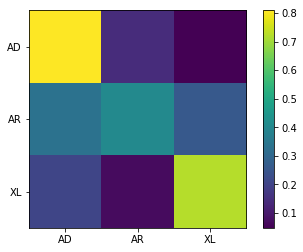

Number of AD 84
Number of AR 54
Number of XL 58
AD Accuracy: 0.8095238095238095
AR Accuracy: 0.4074074074074074
XL Accuracy: 0.7241379310344828
Cohen Kappa 0.49115690410514357


In [321]:
confusionMatrix( true=confident_df[ 'IP' ], predicted=confident_df[ 'Prediction' ], labels=[ 'AD', 'AR', 'XL' ] )

In [352]:
def examineIP( mask ):
    vals = [ labels.index( i ) for i in confident_df[ mask ].IP.values ]
    display( plt.hist( vals ) )

(array([11.,  0.,  0.,  0.,  0.,  9.,  0.,  0.,  0., 29.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

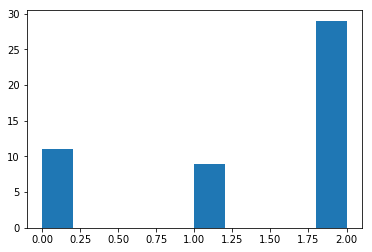

In [353]:
examineIP( confident_df[ 'skipping' ] == 2 )

(array([2., 0., 0., 0., 0., 2., 0., 0., 0., 2.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

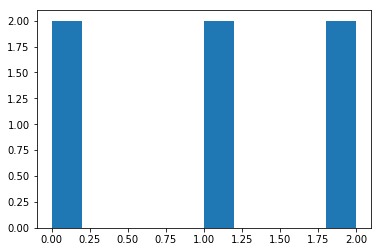

In [354]:
examineIP( confident_df[ 'consang' ] )

(array([79.,  0.,  0.,  0.,  0., 28.,  0.,  0.,  0., 46.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

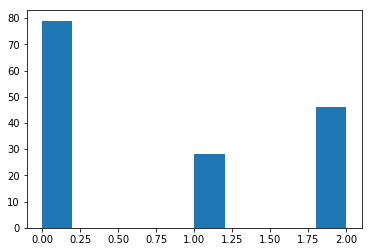

In [355]:
examineIP( confident_df[ 'multGenAff' ] )

(array([31.,  0.,  0.,  0.,  0.,  6.,  0.,  0.,  0.,  3.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

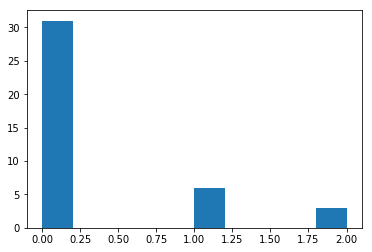

In [356]:
examineIP( confident_df[ 'MAffSon' ] )

(array([38.,  0.,  0.,  0.,  0.,  8.,  0.,  0.,  0.,  6.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

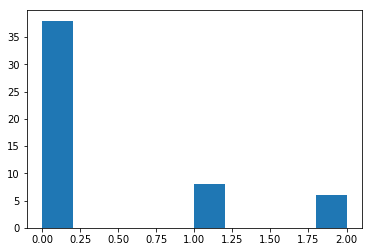

In [357]:
examineIP( confident_df[ 'MAffDau' ] )

(array([13.,  0.,  0.,  0.,  0.,  8.,  0.,  0.,  0.,  4.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

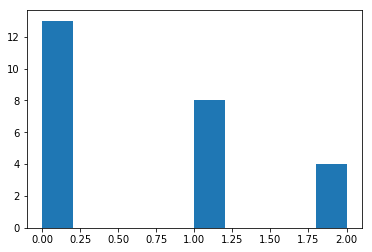

In [358]:
examineIP( confident_df[ 'skipping' ] == 3 )

In [ ]:
all_confident

In [ ]:
import csv
with open('confident_names.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=' ', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    
    for ( graph, fbs ), _, _, _ in all_confident:
        writer.writerow( [ str( graph.studyID ) ] )
        print( graph.studyID )
#     spamwriter.writerow(['Spam'] * 5 + ['Baked Beans'])
#     spamwriter.writerow(['Spam', 'Lovely Spam', 'Wonderful Spam'])

In [37]:
for ( graph, fbs ), _, _, _ in all_confident:
    if( graph.studyID == '302KW' ):
        assert 0

AssertionError: 

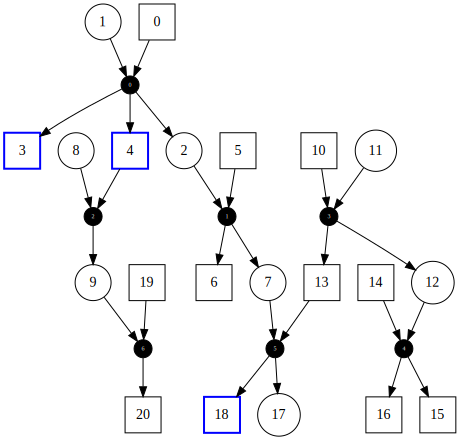

In [38]:
graph.draw()

In [50]:
graph_copy = copy.deepcopy( graph )
graph_copy.useDiagnosisImplication( 'XL' )

model = XLinkedRecessive( [ ( graph_copy, np.array( [] ) ) ], root_strength=10000000000, prior_strength=1000000000, method='EM' )
node_smoothed, marginal = model.stateUpdate()
model.msg.cleanup()

print( marginal )
sorted( node_smoothed.items() )

-28.14142700820244


[(0, array([6.7196237e-22, 1.0000000e+00])),
 (1, array([6.85533282e-09, 9.99999993e-01, 1.85804200e-15])),
 (2, array([1.54946722e-28, 9.99999989e-01, 1.13856300e-08])),
 (3, array([1., 0.])),
 (4, array([1., 0.])),
 (5, array([3.35984134e-21, 1.00000000e+00])),
 (6, array([2.53407661e-11, 1.00000000e+00])),
 (7, array([1.00199345e-17, 9.99999988e-01, 1.23145998e-08])),
 (8, array([4.02315432e-28, 3.84167553e-11, 1.00000000e+00])),
 (9, array([2.19078616e-29, 9.99999999e-01, 1.47851465e-09])),
 (10, array([1.67969231e-22, 1.00000000e+00])),
 (11, array([1.52177277e-30, 2.40092994e-11, 1.00000000e+00])),
 (12, array([1.28229812e-38, 1.00652851e-10, 1.00000000e+00])),
 (13, array([1.59060701e-20, 1.00000000e+00])),
 (14, array([6.71920477e-22, 1.00000000e+00])),
 (15, array([3.37534108e-20, 1.00000000e+00])),
 (16, array([3.37534108e-20, 1.00000000e+00])),
 (17, array([1.84228571e-19, 4.99991264e-01, 5.00008736e-01])),
 (18, array([1., 0.])),
 (19, array([6.71910074e-22, 1.00000000e+00]

In [48]:
graph_copy = copy.deepcopy( graph )
graph_copy.useDiagnosisImplication( 'AR' )

model = AutosomalRecessive( [ ( graph_copy, np.array( [] ) ) ], root_strength=10000000000, prior_strength=1000000000, method='EM' )
node_smoothed, marginal = model.stateUpdate()
model.msg.cleanup()

print( marginal )
sorted( node_smoothed.items() )

-59.66129623725582


[(0, array([8.00542321e-16, 1.99783443e-06, 9.99998002e-01])),
 (1, array([8.00547063e-16, 1.99783794e-06, 9.99998002e-01])),
 (2, array([5.64368684e-17, 1.36121800e-06, 9.99998639e-01])),
 (3, array([1., 0., 0.])),
 (4, array([1., 0., 0.])),
 (5, array([2.45669657e-21, 1.57185196e-11, 1.00000000e+00])),
 (6, array([1.79658460e-19, 6.81728144e-07, 9.99999318e-01])),
 (7, array([3.02042334e-20, 7.24139554e-07, 9.99999276e-01])),
 (8, array([2.24243814e-30, 7.37110351e-12, 1.00000000e+00])),
 (9, array([4.58151911e-20, 1.00000000e+00, 3.65657205e-10])),
 (10, array([1.14732078e-19, 3.97206174e-10, 1.00000000e+00])),
 (11, array([1.14732078e-19, 3.97218425e-10, 1.00000000e+00])),
 (12, array([1.79658450e-19, 1.48663573e-09, 9.99999999e-01])),
 (13, array([1.24920325e-17, 5.83948857e-08, 9.99999942e-01])),
 (14, array([2.16941142e-21, 1.47423874e-11, 1.00000000e+00])),
 (15, array([1.79658449e-19, 1.84012997e-09, 9.99999998e-01])),
 (16, array([1.79658449e-19, 1.84012997e-09, 9.99999998e-0

In [49]:
graph_copy = copy.deepcopy( graph )
graph_copy.useDiagnosisImplication( 'AD' )

model = AutosomalDominant( [ ( graph_copy, np.array( [] ) ) ], root_strength=10000000000, prior_strength=1000000000, method='EM' )
node_smoothed, marginal = model.stateUpdate()
model.msg.cleanup()

print( marginal )
sorted( node_smoothed.items() )

-59.64904244754603


[(0, array([2.82735733e-12, 3.95866031e-04, 9.99604134e-01])),
 (1, array([3.06764418e-13, 3.95879760e-04, 9.99604120e-01])),
 (2, array([2.19618803e-30, 5.62000472e-13, 1.00000000e+00])),
 (3, array([0., 1., 0.])),
 (4, array([0., 1., 0.])),
 (5, array([2.06144922e-30, 7.23575766e-21, 1.00000000e+00])),
 (6, array([3.06555134e-20, 2.45952818e-18, 1.00000000e+00])),
 (7, array([1.02769529e-20, 2.10688744e-10, 1.00000000e+00])),
 (8, array([1.19643819e-29, 1.34970026e-20, 1.00000000e+00])),
 (9, array([8.47332582e-28, 4.21285758e-10, 1.00000000e+00])),
 (10, array([1.73159776e-30, 7.23575765e-21, 1.00000000e+00])),
 (11, array([1.80800955e-31, 7.23528979e-21, 1.00000000e+00])),
 (12, array([2.93433597e-38, 6.14725261e-19, 1.00000000e+00])),
 (13, array([4.14869611e-20, 2.10650905e-10, 1.00000000e+00])),
 (14, array([1.12798161e-37, 6.74864222e-21, 1.00000000e+00])),
 (15, array([3.06555134e-20, 2.45905460e-18, 1.00000000e+00])),
 (16, array([3.06555134e-20, 2.45905460e-18, 1.00000000e+0

In [118]:
[ int( x ) for x in np.linspace( 0, 71, 6 ) ]

[0, 14, 28, 42, 56, 71]

In [119]:
np.arange( 30, 34 )

array([30, 31, 32, 33])

---------------------------
609DV
AD probability: 1.5580041921843879e-18
AR probability: 2.308599483862387e-16
XL probability: 1.0
Node [AA,Aa,aa]
   0 [0. 1.]
   1 [0. 1. 0.]
   2 [0. 1. 0.]
   3 [1. 0.]
   4 [0. 1.]
   5 [0. 1. 0.]
   6 [0. 1.]
   7 [1. 0.]
   8 [1. 0.]
   9 [1. 0.]
  10 [0. 1.]
  11 [1. 0.]
  12 [0. 0. 1.]
  13 [0. 1.]
  14 [0. 1.]
  15 [0. 1. 0.]
  16 [0. 1.]
  17 [0.    0.334 0.334 0.    0.332]
  18 [0. 0. 1.]
  19 [0. 1.]
  20 [0. 1.]
  21 [0. 1. 0.]
  22 [0. 0. 1.]
  23 [0. 1. 0.]
  24 [0. 1. 0.]
  25 [0. 1.]
  26 [0. 0. 1.]
  27 [0. 1.]
  28 [0. 1. 0.]
  29 [0. 1.]
  30 [0. 1. 0.]


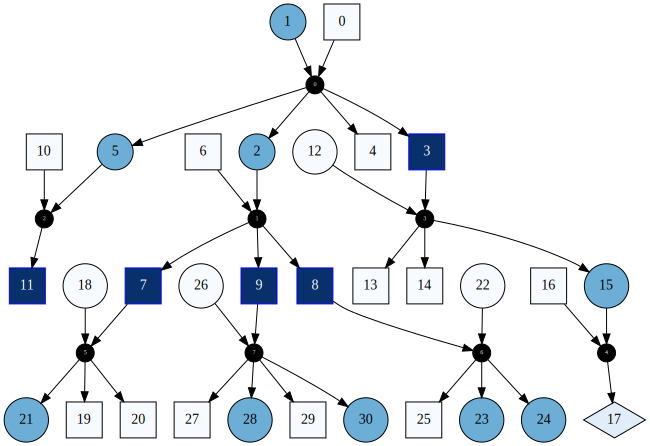

In [697]:
for g, fbs in graphs:
#     if( g.studyID != '6327JA' ):
    if( g.studyID != '609DV' ):
        continue
    if( g.inheritancePattern == 'XL' ):
        print( '---------------------------' )
        print( g.studyID )
        h = copy.deepcopy( g )
#         h.setPossibleLatentStates( [6,2], [0,2] )
        res = distributionComparison([ h, fbs ], 
                               samples=10, 
                               root_strength=1000000, 
                               strength=1000000, 
                               set_latent_states=False, 
                               set_root_latent_states=False )
        
        pred, probs, ad_scores, ar_scores, xl_scores, ad_eval, ar_eval, xl_eval = res
        print( 'AD probability:', probs[ 0 ] )
        print( 'AR probability:', probs[ 1 ] )
        print( 'XL probability:', probs[ 2 ] )
        display( xl_eval.draw() )

In [181]:
U, V = xl_eval.msg.filter()

/home/eddie/anaconda3/envs/GenModel/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


Node [AA,Aa,aa]
   0 [0. 1.]
   1 [0. 0. 1.]
   2 [0. 0. 1.]
   3 [0. 0. 1.]
   4 [0. 0. 1.]
   5 [0. 1.]
   6 [0. 1.]
   7 [0. 1.]
   8 [0. 1.]
   9 [0.  0.  0.5 0.  0.5]
  10 [0. 1.]
  11 [0. 1.]
  12 [0. 0. 1.]
  13 [1. 0. 0.]
  14 [0. 1.]
  15 [1. 0. 0.]
  16 [0. 0. 1.]
  17 [0. 0. 1.]
  18 [0. 1.]
  19 [0. 0. 1.]
  20 [0. 1.]
  21 [0. 1.]
  22 [0. 0. 1.]
  23 [0. 1. 0.]
  24 [0. 0. 1.]
  25 [0. 1.]
  26 [0. 1.]
  27 [0.582 0.418]
  28 [0. 1. 0.]


/home/eddie/anaconda3/envs/GenModel/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


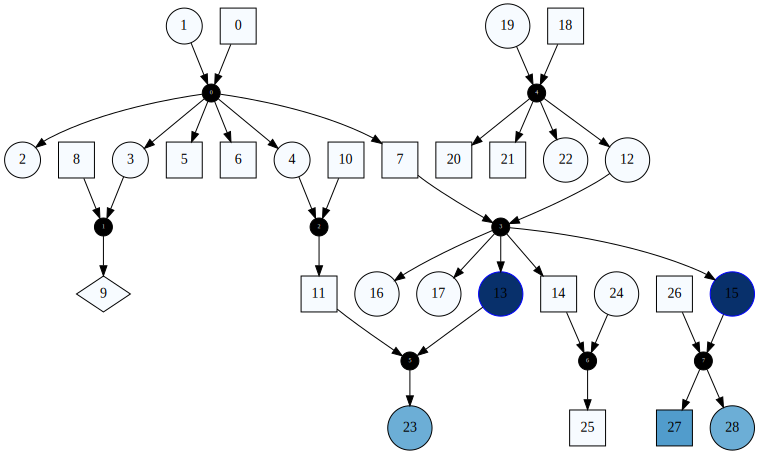

In [694]:
xl_eval.draw()

Male [XY,xY]
   0 [0. 1.]
   3 [1. 0.]
   4 [0. 1.]
   6 [0. 1.]
   7 [1. 0.]
   8 [1. 0.]
   9 [1. 0.]
  10 [0. 1.]
  11 [1. 0.]
  13 [0. 1.]
  14 [0. 1.]
  16 [0. 1.]
  19 [0. 1.]
  20 [0. 1.]
  25 [0. 1.]
  27 [0. 1.]
  29 [0. 1.]
Female [XX,Xx,xx]
     1 [0. 1. 0.]
     2 [0. 1. 0.]
     5 [0. 1. 0.]
    12 [0. 0. 1.]
    15 [0. 1. 0.]
    18 [0. 0. 1.]
    21 [0. 1. 0.]
    22 [0. 0. 1.]
    23 [0. 1. 0.]
    24 [0. 1. 0.]
    26 [0. 0. 1.]
    28 [0. 1. 0.]
    30 [0. 1. 0.]
Unknown [XX,  Xx,  xx,  XY,  xY  ]
     17 [0.   0.33 0.33 0.   0.33]


/home/eddie/anaconda3/envs/GenModel/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


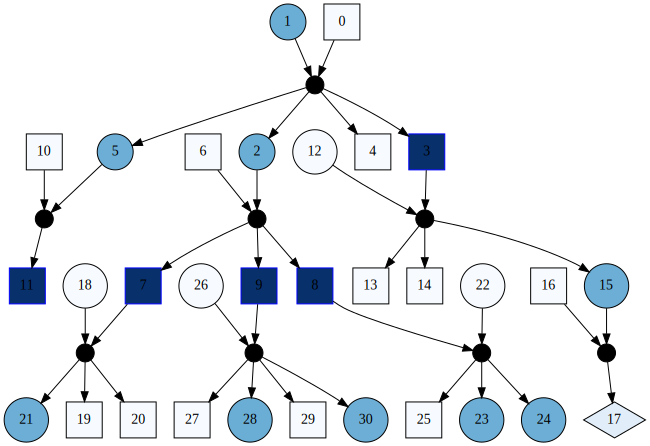

In [291]:
xl_eval.draw()

Node [AA,Aa,aa]
   0 [0.    0.042 0.958]
   1 [0. 1. 0.]
   2 [0. 1. 0.]
   3 [1. 0. 0.]
   4 [0.    0.507 0.493]
   5 [0.    0.176 0.824]
   6 [0. 1. 0.]
   7 [1. 0. 0.]
   8 [1. 0. 0.]
   9 [1. 0. 0.]
  10 [0.    0.016 0.984]
  11 [1. 0. 0.]
  12 [0. 0. 1.]
  13 [0. 1. 0.]
  14 [0. 1. 0.]
  15 [0. 1. 0.]
  16 [0. 0. 1.]
  17 [0.  0.5 0.5]
  18 [0. 0. 1.]
  19 [0. 1. 0.]
  20 [0. 1. 0.]
  21 [0. 1. 0.]
  22 [0. 0. 1.]
  23 [0. 1. 0.]
  24 [0. 1. 0.]
  25 [0. 1. 0.]
  26 [0. 0. 1.]
  27 [0. 1. 0.]
  28 [0. 1. 0.]
  29 [0. 1. 0.]
  30 [0. 1. 0.]


/home/eddie/anaconda3/envs/GenModel/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


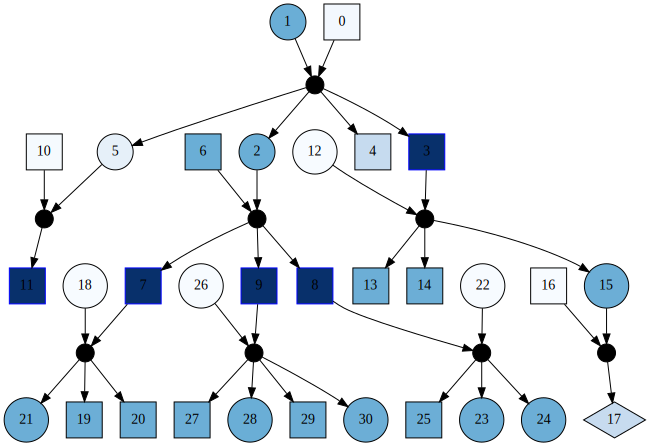

In [293]:
ar_eval.draw()

/home/eddie/anaconda3/envs/GenModel/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


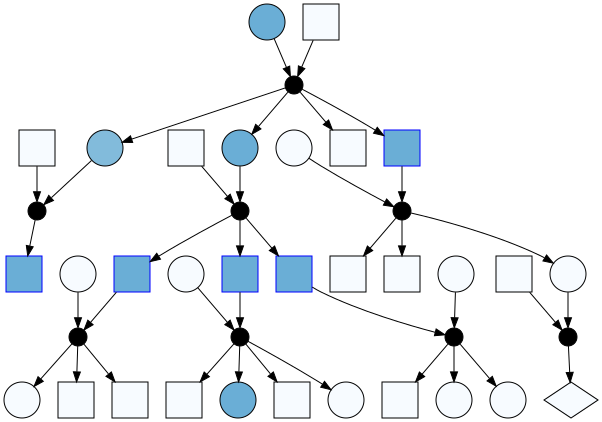

In [268]:
ad_eval.draw()

In [263]:
U, V = ar_eval.msg.filter()
node_smoothed = dict( ar_eval.msg.nodeSmoothed( U, V, ar_eval.msg.nodes ) )
for node, probs in node_smoothed.items():
    with np.printoptions( precision=3, suppress=True ):
        print( node, np.exp( probs ) )

0 [0.    0.042 0.958]
1 [0. 1. 0.]
2 [0. 1. 0.]
3 [1. 0. 0.]
4 [0.    0.507 0.493]
5 [0.    0.176 0.824]
6 [0. 1. 0.]
7 [1. 0. 0.]
8 [1. 0. 0.]
9 [1. 0. 0.]
10 [0.    0.016 0.984]
11 [1. 0. 0.]
12 [0. 0. 1.]
13 [0. 1. 0.]
14 [0. 1. 0.]
15 [0. 1. 0.]
16 [0. 0. 1.]
17 [0.  0.5 0.5]
18 [0. 0. 1.]
19 [0. 1. 0.]
20 [0. 1. 0.]
21 [0. 1. 0.]
22 [0. 0. 1.]
23 [0. 1. 0.]
24 [0. 1. 0.]
25 [0. 1. 0.]
26 [0. 0. 1.]
27 [0. 1. 0.]
28 [0. 1. 0.]
29 [0. 1. 0.]
30 [0. 1. 0.]


/home/eddie/anaconda3/envs/GenModel/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


In [170]:
xl_eval.msg.nodes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

/home/eddie/anaconda3/envs/GenModel/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


[8.24994190e-01 1.74998409e-01 7.40012627e-06]
XL
Node [AA,Aa,aa]
   0 [0.    0.004 0.996]
   1 [0.    0.004 0.996]
   2 [0.    0.004 0.996]
   3 [0.    0.004 0.996]
   4 [0.    0.003 0.997]
   5 [0.    0.004 0.996]
   6 [0.    0.004 0.996]
   7 [0.    0.109 0.891]
   8 [0. 0. 1.]
   9 [0.    0.002 0.998]
  10 [0. 0. 1.]
  11 [0.    0.001 0.999]
  12 [0.    0.109 0.891]
  13 [1. 0. 0.]
  14 [0.    0.073 0.927]
  15 [1. 0. 0.]
  16 [0.    0.073 0.927]
  17 [0.    0.073 0.927]
  18 [0.    0.004 0.996]
  19 [0.    0.004 0.996]
  20 [0.    0.004 0.996]
  21 [0.    0.004 0.996]
  22 [0.    0.004 0.996]
  23 [0. 1. 0.]
  24 [0. 0. 1.]
  25 [0.    0.036 0.964]
  26 [0. 0. 1.]
  27 [0. 1. 0.]
  28 [0. 1. 0.]


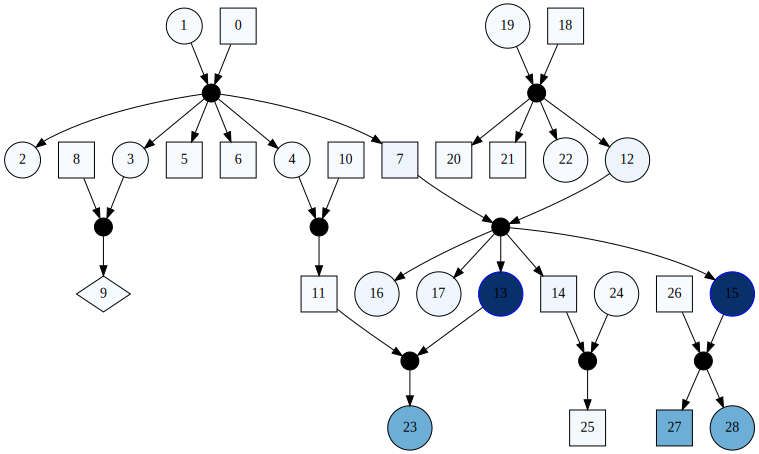

In [472]:
for g, fbs in graphs:
    if( g.studyID == 'NEI_INVNL899LP6' ):
        res = distributionComparison([ g, fbs ], 
                               samples=1, 
                               root_strength=1000000, 
                               strength=1000000, 
                               set_latent_states=True, 
                               set_root_latent_states=False )
        
        pred, probs, ad_scores, ar_scores, xl_scores, ad_eval, ar_eval, xl_eval = res
        print( probs )
        print( g.inheritancePattern )
#         display( ad_eval.draw() )
        display( ar_eval.draw() )
#         display( xl_eval.draw() )


In [215]:
import scipy.stats
K = 4
J = 3
T = 10
pi0 = np.random.random( K )
pi0 /= pi0.sum()
pi0 = np.log( pi0 )

pi = np.random.random( ( K, K ) )
pi /= pi.sum( axis=1 )[ :, None ]
pi = np.log( pi )

y = np.random.choice( J, T )

L = np.random.random( ( K, J ) )
L /= L.sum( axis=1 )[ :, None ]
L_ = np.log( L )
L = L_.T[ y ]

In [216]:
def forward():
    alpha = np.zeros( ( T, K ) )
    alpha[ 0 ] = pi0 + L[ 0 ]
    for t in range( 1, T ):
        alpha[ t ] = L[ t ] + logsumexp( pi + alpha[ t - 1 ][ :, None ], axis=0 )
    return alpha
def backward():
    beta = np.zeros( ( T, K ) )
    for t in range( T-2, -1, -1 ):
        beta[ t ] = logsumexp( pi + L[ t + 1 ] + beta[ t + 1 ], axis=1 )
    return beta

In [221]:
alpha, beta = forward(), backward()
for t in range( T-1 ):
    joint = alpha[ t ][ :, None ] + pi + L[ t + 1 ] + beta[ t + 1 ]
    j1 = logsumexp( joint, axis=0 )
    j2 = logsumexp( joint, axis=1 )
    assert np.allclose( j2, alpha[ t ] + beta[ t ] )
    assert np.allclose( j1, alpha[ t+1 ] + beta[ t+1 ] )

In [241]:
def viterbiGen():
    M = np.zeros( ( T, K ) )
    N = np.zeros( ( T, K ) )
    M[ 0 ] = pi0 + L[ 0 ]
    for t in range( 1, T ):
        val = L[ t ] + pi + M[ t - 1 ][ :, None ]
        M[ t ] = np.max( val, axis=0 )
        N[ t ] = np.argmax( val, axis=0 )
    return M, N
def backwardViterbiChoose( M, N ):
    answer = np.zeros( T, dtype=int )
    answer[ -1 ] = np.argmax( M[ -1 ] )
    for t in range( T-2, -1, -1 ):
        answer[ t ] = N[ t, answer[ t + 1 ] ]
    return answer
def viterbi():
    return backwardViterbiChoose( *viterbiGen() )

In [242]:
viterbi()

array([0, 1, 1, 3, 0, 3, 3, 0, 3, 0])

In [243]:
viterbiGen()

(array([[ -3.00082581,  -1.87036697,  -3.18989033,  -3.97035402],
        [ -4.59916731,  -3.91971243,  -5.78673863,  -4.09602943],
        [ -6.44481769,  -5.96905788,  -7.71948773,  -6.14537488],
        [ -8.11995172,  -8.52817942,  -8.43997601,  -9.39236667],
        [-10.98364985, -10.57752487, -11.45327735,  -9.93623297],
        [-12.28502123, -12.62687032, -13.55969127, -12.27825495],
        [-14.16497614, -15.41611636, -13.86833528, -14.01147324],
        [-16.36026149, -16.57606586, -17.09914035, -15.9812574 ],
        [-18.33004565, -18.62541132, -19.60471569, -18.17654275],
        [-20.15111958, -21.18453285, -20.33451411, -21.34397324]]),
 array([[0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [3., 1., 3., 1.],
        [3., 1., 3., 1.],
        [2., 1., 0., 0.],
        [3., 1., 3., 3.],
        [3., 1., 0., 0.],
        [3., 2., 2., 0.],
        [3., 1., 3., 0.],
        [3., 1., 0., 0.]]))

In [250]:
last = np.argmax( pi0 + L[ 0 ] + beta[ 0 ] )
for t in range( T ):
    print( last )
    prob = ( pi + L[ t ] + beta[ t ] )[ last, : ]
    last = np.argmax( prob )
print( last )    
    

1
1
1
1
1
1
1
3
0
3
0


In [564]:
df[ 'moreMales' ] = df[ 'percentageAffMales' ] > 0.7
confident_df[ 'moreMales' ] = confident_df[ 'percentageAffMales' ] > 0.7

/home/eddie/anaconda3/envs/GenModel/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [565]:
confident_df

,numAff,multGenAff,MAffSon,MAffDau,skipping,sibAff,halfSibAff,cousAff,MFAff,ons20M,...,nAffMales,nAffFemales,nAffUnknowns,percentageAffMales,AD_Prob,AR_Prob,XL_Prob,IP,Prediction,moreMales
Patient ID,,,,,,,,,,,,,,,,,,,,,
1022AS,1,False,False,False,1,1,1,1,3,False,...,0.0,1.0,0.0,0.000000,1.952661e-01,8.047339e-01,4.261081e-12,AR,AR,False
1046DA,4,True,False,False,3,1,1,1,3,False,...,0.0,4.0,0.0,0.000000,1.000000e+00,6.022719e-10,1.666467e-27,AD,AD,False
1084LN,8,True,True,True,2,3,1,3,1,Unknown,...,5.0,3.0,0.0,0.625000,1.000000e+00,2.253291e-19,3.500799e-34,AD,AD,False
1089JB,6,True,False,False,2,1,1,2,2,Unknown,...,4.0,0.0,0.0,1.000000,9.807848e-12,4.327722e-09,1.000000e+00,XL,XL,True
167MW,3,True,False,False,1,3,1,1,3,False,...,0.0,2.0,0.0,0.000000,7.327454e-02,9.267245e-01,9.460936e-07,AR,AR,False
189DC,2,True,False,True,1,1,1,1,1,Unknown,...,1.0,1.0,0.0,0.500000,9.999302e-01,3.948129e-05,3.028360e-05,AD,AD,False
2042JD,1,False,False,False,1,1,1,1,3,False,...,0.0,1.0,0.0,0.000000,8.048304e-02,9.195170e-01,8.203358e-23,AR,AR,False
2065GE,2,True,False,False,2,1,1,1,2,True,...,2.0,0.0,0.0,1.000000,5.044354e-07,5.250900e-06,9.999942e-01,XL,XL,True
2079NC,6,True,True,True,1,1,1,3,1,True,...,4.0,2.0,0.0,0.666667,1.000000e+00,3.489472e-26,5.222768e-27,AD,AD,False


In [653]:
def evalFeature( df, name, value=True ):
    if( isinstance( name, list ) ):
        ip = df[ name[ 0 ] ] == value[ 0 ]
        pred = df[ name[ 0 ] ] == value[ 0 ]
        for i, ( n, v ) in enumerate( zip( name, value ) ):
            if( i == 0 ):
                continue
                
            ip &= df[ n ] == v
            pred &= df[ n ] == v
        ip = df[ ip ][ 'IP' ]
        pred = df[ pred ][ 'Prediction' ]
    else:
        ip = df[ df[ name ] == value ][ 'IP' ]
        pred = df[ df[ name ] == value ][ 'Prediction' ]
    confusionMatrix( true=ip, predicted=pred, labels=[ 'AD', 'AR', 'XL' ] )
    return ip, pred

In [654]:
ad_features = [
    [ [ 'moreMales', 'multGenAff' ], [ False, True ] ], # Multiple generations affected and there 
                                                        # is an equal ratio of males and females
    [ 'cousAff', 3 ] # Cousins are affected, but paternal cousins only
]

In [655]:
ar_features = [
    [ 'MFAff', 3 ], # Only females are affected
    [ [ 'moreMales', 'multGenAff' ], [ False, False ] ] # One generation and same prob
]

In [656]:
xl_features = [
    [ 'cousAff', 2 ], # Cousins are affected, but maternal cousins only
    [ 'skipping', 2 ], # Females only are skipped
    [ 'MAffSon', False ], # No male to male
    [ 'moreMales', True ] # More males affected than females
]

[[56  8  1]
 [14  3  0]
 [11  1  4]]
[[0.86153846 0.12307692 0.01538462]
 [0.82352941 0.17647059 0.        ]
 [0.6875     0.0625     0.25      ]]


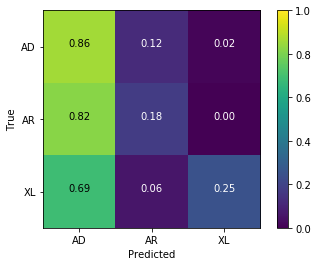

Number of AD 65
Number of AR 17
Number of XL 16
Accuracy: 0.6428571428571429
AD Accuracy: 0.8615384615384616
AR Accuracy: 0.17647058823529413
XL Accuracy: 0.25
Cohen Kappa 0.15413070283600494
[[13  0  0]
 [ 2  0  0]
 [ 3  0  0]]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


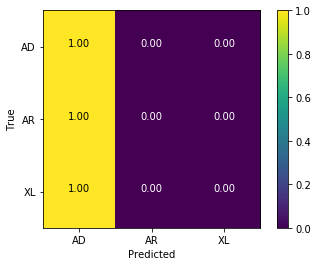

Number of AD 13
Number of AR 2
Number of XL 3
Accuracy: 0.7222222222222222
AD Accuracy: 1.0
AR Accuracy: 0.0
XL Accuracy: 0.0
Cohen Kappa 0.0


In [657]:
for_ad = []
for name, value in ad_features:
    true_ips, preds = evalFeature( confident_df, name, value )
    mask = true_ips == 'AD'
    for_ad.append( preds[ mask ] )    

[[ 5  8  0]
 [ 1 18  0]
 [ 2  2  0]]
[[0.38461538 0.61538462 0.        ]
 [0.05263158 0.94736842 0.        ]
 [0.5        0.5        0.        ]]


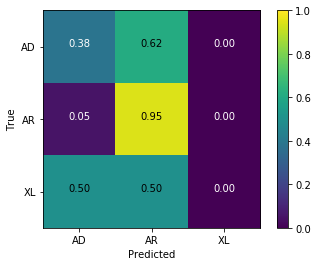

Number of AD 13
Number of AR 19
Number of XL 4
Accuracy: 0.6388888888888888
AD Accuracy: 0.38461538461538464
AR Accuracy: 0.9473684210526315
XL Accuracy: 0.0
Cohen Kappa 0.2909090909090909
19
[[ 0  4  0]
 [ 2 19  0]
 [ 0  3  0]]
[[0.        1.        0.       ]
 [0.0952381 0.9047619 0.       ]
 [0.        1.        0.       ]]


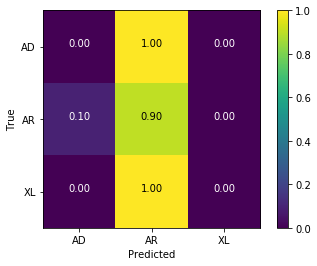

Number of AD 4
Number of AR 21
Number of XL 3
Accuracy: 0.6785714285714286
AD Accuracy: 0.0
AR Accuracy: 0.9047619047619048
XL Accuracy: 0.0
Cohen Kappa -0.09565217391304337
21


In [677]:
for_ar = []
for name, value in ar_features:
    true_ips, preds = evalFeature( confident_df, name, value )
    mask = true_ips == 'AR'
    print( mask.sum() )
    for_ar.append( preds[ mask ] )    

[[14  0  0]
 [ 3  2  2]
 [ 1  0 14]]
[[1.         0.         0.        ]
 [0.42857143 0.28571429 0.28571429]
 [0.06666667 0.         0.93333333]]


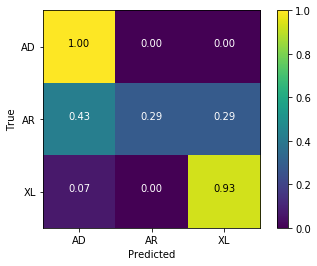

Number of AD 14
Number of AR 7
Number of XL 15
Accuracy: 0.8333333333333334
AD Accuracy: 1.0
AR Accuracy: 0.2857142857142857
XL Accuracy: 0.9333333333333333
Cohen Kappa 0.7265822784810128
15
[[ 8  2  1]
 [ 1  1  7]
 [ 0  0 29]]
[[0.72727273 0.18181818 0.09090909]
 [0.11111111 0.11111111 0.77777778]
 [0.         0.         1.        ]]


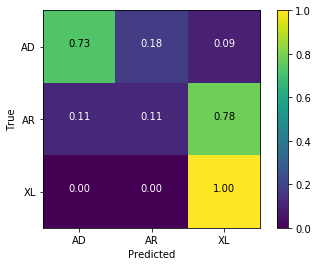

Number of AD 11
Number of AR 9
Number of XL 29
Accuracy: 0.7755102040816326
AD Accuracy: 0.7272727272727273
AR Accuracy: 0.1111111111111111
XL Accuracy: 1.0
Cohen Kappa 0.5515806988352745
29
[[39 11  3]
 [12 22 14]
 [10  4 41]]
[[0.73584906 0.20754717 0.05660377]
 [0.25       0.45833333 0.29166667]
 [0.18181818 0.07272727 0.74545455]]


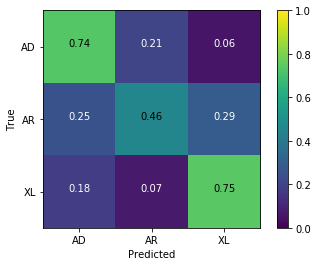

Number of AD 53
Number of AR 48
Number of XL 55
Accuracy: 0.6538461538461539
AD Accuracy: 0.7358490566037735
AR Accuracy: 0.4583333333333333
XL Accuracy: 0.7454545454545455
Cohen Kappa 0.47796988287785847
55
[[12  0  3]
 [ 2  0 14]
 [ 1  0 38]]
[[0.8        0.         0.2       ]
 [0.125      0.         0.875     ]
 [0.02564103 0.         0.97435897]]


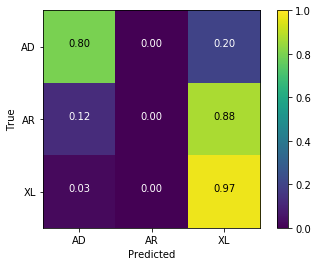

Number of AD 15
Number of AR 16
Number of XL 39
Accuracy: 0.7142857142857143
AD Accuracy: 0.8
AR Accuracy: 0.0
XL Accuracy: 0.9743589743589743
Cohen Kappa 0.4466403162055337
39


In [676]:
for_xl = []
for name, value in xl_features:
    true_ips, preds = evalFeature( confident_df, name, value )
    mask = true_ips == 'XL'
    print( mask.sum() )
    for_xl.append( preds[ mask ] )    

In [660]:
for_xl

[Patient ID
 1089JB             XL
 3359RG             XL
 377LP              XL
 4092ES             XL
 4961BR             XL
 5044AL             XL
 5064JH             XL
 5500MB             XL
 5793KB             XL
 609DV              XL
 671AH              XL
 NEI_INVEN248YME    XL
 NEI_INVFV081ZTY    XL
 NEI_INVGD997YX5    XL
 NEI_INVLG761DLX    AD
 Name: Prediction, dtype: object, Patient ID
 1089JB             XL
 2065GE             XL
 302KW              XL
 3239PB             XL
 3359RG             XL
 3489ZM             XL
 3490IM             XL
 377LP              XL
 384TD              XL
 4071CW             XL
 4092ES             XL
 409MB              XL
 425JY              XL
 4545MP             XL
 4561ER             XL
 4961BR             XL
 5044AL             XL
 5064JH             XL
 5500MB             XL
 5991KP             XL
 609DV              XL
 6327JA             XL
 671AH              XL
 992CK              XL
 NEI_INVDZ481EPZ    XL
 NEI_INVGD997YX5    XL


In [661]:
for_ad = np.hstack( for_ad )
for_ar = np.hstack( for_ar )
for_xl = np.hstack( for_xl )
true = np.hstack( [ [ 'AD' for _ in range( for_ad.shape[ 0 ] ) ], [ 'AR' for _ in range( for_ar.shape[ 0 ] ) ], [ 'XL' for _ in range( for_xl.shape[ 0 ] ) ] ] )
all_preds = np.hstack( [ for_ad, for_ar, for_xl ] )

[[ 69   8   1]
 [  3  37   0]
 [ 12   4 122]]
[[0.88461538 0.1025641  0.01282051]
 [0.075      0.925      0.        ]
 [0.08695652 0.02898551 0.88405797]]


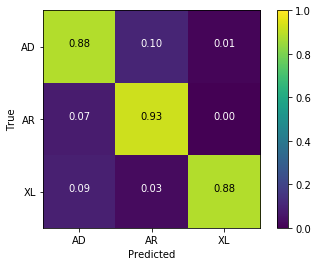

Number of AD 78
Number of AR 40
Number of XL 138
Accuracy: 0.890625
AD Accuracy: 0.8846153846153846
AR Accuracy: 0.925
XL Accuracy: 0.8840579710144928
Cohen Kappa 0.8210237203495631


In [662]:
# Accuracy on pedigrees that contain high level features and are what we expected
confusionMatrix( true=true, predicted=all_preds, labels=[ 'AD', 'AR', 'XL' ] )

In [664]:
for_xl

array(['XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL',
       'XL', 'XL', 'XL', 'AD', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL',
       'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL',
       'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL',
       'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL',
       'XL', 'XL', 'XL', 'XL', 'AD', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL',
       'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'AD', 'AD', 'XL', 'XL', 'AR',
       'AD', 'AR', 'XL', 'AD', 'XL', 'XL', 'AD', 'AD', 'AR', 'XL', 'XL',
       'XL', 'AD', 'AD', 'XL', 'AR', 'XL', 'AD', 'XL', 'XL', 'XL', 'XL',
       'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL',
       'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL',
       'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'XL', 'AD', 'XL', 'XL', 'XL',
       'XL', 'XL', 'XL', 'XL', 'XL', 'XL'], dtype=object)

In [693]:
xLinkedRecessivePriors()[ 1 ][ 2 ] - 1

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [670]:
( confident_df[ 'IP' ] == 'XL' ).sum()

58

In [671]:
( confident_df[ 'IP' ] == 'AR' ).sum()

54

In [672]:
( confident_df[ 'IP' ] == 'AD' ).sum()

84

In [675]:
for_xl.shape

(138,)